# CPSC-610-Project - Predicting Monthly Electricity Consumption
-------------------------------------------------------
### Professor: Mohannad AlMousa
-------------------------------------------------------
#### Students:
   * Jorge Roberto Ponce Martínez - NF1026980
   * Gina Sussileth Lutfallah Reyes - NF1024061
   * Luis Enrique Villalobos Socualaya - NF1031293
   * Isabel Marcia Chauca Reyes - NF1023326

#### Date: December 7th, 2025.

## Project Overview

This project explores energy consumption patterns across hundreds of properties in Ontario.
The dataset consists of CSV files derived from the ENERGY STAR Portfolio Manager system.

Each CSV describes a different part of the data ecosystem:
   * Property characteristics
   * Meters installed at each property
   * Monthly energy consumption readings
   * How floor area is allocated to different use types

Each row in the meter entries dataset represents one monthly meter reading for a specific property.

Your main objective is to build a machine learning model that predicts monthly electricity consumption (usage) for buildings, using only readings from Electric – Grid meters (measured in kWh). 

The prediction target comes from the meter entries data, and you will need to extract the correct column and filter the dataset appropriately. You can use the attributes in these different files to help you in training your model.


### Inicialización

#### Libraries

In [1]:
# -----Libraries-----
# --- General Libraries
import os

# --- Data Manipulation Libraries
import pandas as pd
import numpy as np

# --- Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# --- Machine Learning Libraries
# -- Scikit-Learn Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# -- Scikit-Learn Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline

# -- Scikit-Learn Metrics
from sklearn.metrics import mean_squared_error, r2_score


#### Variables and Constants

In [2]:
# -----Constansts
# ----Path file of data sets
c_pathfile=r"Data\\"

# ----Random state & Data handle variables
c_random_state = 56106
c_test_size = 0.20

# ----Format for display
pd.set_option('display.float_format', '{:,.4f}'.format)

#### Reutilizable Functions

In [3]:
def load_csv_to_dataframe(
    file_path,
    show_info=False, show_describe=False,
    show_head=False, head_rows=5,
    show_sample=False, sample_rows=5,
    parse_date=False, parse_index=0
):
    """
    Loads a CSV file into a pandas DataFrame and optionally displays information, the first few rows,
    or random samples.
    If parse_date flag is True the function will read the csv file with the parameters 'index_col' and
    'parse_dates'. In case the index of the date to parse is not in the first position you can use the
    parameter 'parse_index' to indicate the index in the file to parse.

    Args:
        file_path (str): The path to the CSV file.
        show_info (bool, optional): Flag to display DataFrame information. Defaults to False.
        show_describe (bool, optional): Flag to display DataFrame describe info. Defaults to False.
        show_head (bool, optional): Flag to display the first n_rows of the DataFrame. Defaults to False.
        head_rows (int, optional): Number of rows to show with '.head' of DF
        show_sample (bool, optional): Flag to display random samples of the DataFrame. Defaults to False.
        sample_rows (int, optional): Number of rows to show a sample of DF

    Returns:
        pandas.DataFrame: The DataFrame loaded from the CSV file.
    """

    # ----Try block in case of a runtimeerror reading files
    try:
        # ---Read file and get file name
        if parse_date == True:
            df = pd.read_csv(file_path, index_col=[parse_index], parse_dates=[parse_index])
        else:
            df = pd.read_csv(file_path)

        # --Get file name
        file_name = os.path.basename(file_path)
        
        # ---Show info of the new DataFrame if requested
        if show_info:
            print(f"\n***********DataFrame {file_name}***********")
            display(df.info())

        # ---Show info of the new DataFrame if requested
        if show_describe:
            print(f"\n***********DataFrame Describe {file_name}***********")
            display(df.describe())            
            
        # ---Show first rows of DataFrame if requested
        if show_head:
            print(f"\n***********First {head_rows} registers of DataFrame {file_name}***********")
            display(df.head(head_rows))

        # ---Show sample rows of DataFrame if requested
        if show_sample:
            print(f"\n***********Sampled registers {sample_rows} of DataFrame {file_name}***********")
            display(df.sample(sample_rows))
            
        return df

    # -File not found exception
    except FileNotFoundError:
        print(f"\nError: File not found at {file_path}")
        return None
    # -Any other runtime error
    except Exception as e:
        print(f"\nAn error occurred: {e}")
        return None

In [4]:
# ----- Consumption by Property Type (Subplots with Zoom)
def plot_property_type_subplots(df):
    """
    Plots boxplots for each Property Type in a 3x5 grid.
    Dynamically sets x-axis limits to zoom in on the main distribution (whiskers),
    avoiding flattening caused by extreme outliers.
    """
    # ---- 1. Get unique property types
    property_types = df['Property_Type'].unique()
    
    # ---- 2. Setup the grid (3 rows x 5 columns)
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(24, 15), constrained_layout=True)
    axes_flat = axes.flatten() # Flatten 2D grid to 1D array for easy looping
    
    # ---- 3. Loop through each property type
    for i, prop_type in enumerate(property_types):
        # --- Safety check to avoid index error if more than 15 types exist
        if i >= len(axes_flat): 
            break
            
        ax = axes_flat[i]
        
        # --- Filter data for this specific property type
        subset = df[df['Property_Type'] == prop_type]
        
        # --- Create the boxplot
        sns.boxplot(
            data=subset, 
            x="Electricity_Usage_kWh", 
            ax=ax,
            color='skyblue' 
        )
        
        # --- ZOOM LOGIC (Calculate Whiskers) ---
        # We calculate Q1, Q3, and IQR manually to define the view limits
        if not subset.empty:
            Q1 = subset['Electricity_Usage_kWh'].quantile(0.25)
            Q3 = subset['Electricity_Usage_kWh'].quantile(0.75)
            IQR = Q3 - Q1
            
            # --Standard whiskers extend to 1.5 * IQR
            #       We add a small % buffer so the whiskers don't touch the edge of the plot
            view_min = max(0, Q1 - 1.5 * IQR - (0.5 * IQR) ) # Usage can't be negative
            view_max = Q3 + 1.5 * IQR + (0.5 * IQR) 
            
            # -- Apply the limits
            ax.set_xlim(left=view_min, right=view_max)
        
        # -- Formatting
        ax.set_title(prop_type, fontsize=11, fontweight='bold', pad=10)
        ax.set_xlabel("Usage (kWh)", fontsize=9)
        ax.set_ylabel("") # Remove redundant y-label
    
    # ---- 4. Hide any unused subplots (if fewer than 15 types)
    for j in range(i + 1, len(axes_flat)):
        axes_flat[j].axis('off')
        
    plt.suptitle("Electricity Usage Distribution by Property Type (Outliers Trimmed)", fontsize=18, y=1.02)
    plt.show()

In [5]:
# ----- 1. Define Evaluation Function
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Calculates and prints RMSE and R2 scores for both Train and Test sets.
    """
    # ---- Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # ---- Calculate Metrics
    # --- RMSE (Root Mean Squared Error)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    # --- R2 Score
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    print(f"--- {model_name} Performance ---")
    print(f"Training RMSE: {rmse_train:.4f} | R2: {r2_train:.4f}")
    print(f"Testing  RMSE: {rmse_test:.4f}  | R2: {r2_test:.4f}")
    print("-" * 30)
    
    return y_pred_test # Return test predictions for plotting later

### Datasets Loading

In [6]:
# ----- Load Data to DataFrames

In [7]:
# --- Meters Entries DataFrame
df_meter_entries = load_csv_to_dataframe(
    (c_pathfile + "meter_entries.csv"),
    show_info = True, show_describe = True,
    show_head = True, head_rows = 5,
    show_sample = True, sample_rows = 5
)


***********DataFrame meter_entries.csv***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26222 entries, 0 to 26221
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Property Name               26222 non-null  object 
 1   Portfolio Manager ID        26222 non-null  int64  
 2   Portfolio Manager Meter ID  26222 non-null  int64  
 3   Meter Name                  26222 non-null  object 
 4   Meter Type                  26222 non-null  object 
 5   Meter Consumption ID        26222 non-null  int64  
 6   Start Date                  26222 non-null  object 
 7   End Date                    26222 non-null  object 
 8   Usage/Quantity              26222 non-null  float64
 9   Usage Units                 26222 non-null  object 
 10  Cost ($)                    26222 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 2.2+ MB


None


***********DataFrame Describe meter_entries.csv***********


,Portfolio Manager ID,Portfolio Manager Meter ID,Meter Consumption ID,Usage/Quantity
count,"26,222.0000","26,222.0000","26,222.0000","26,222.0000"
mean,"34,999,900.3983","190,110,367.9278","8,451,534,933.6880","55,434.4347"
std,520.3779,"43,394.4117","16,758.6086","342,074.5867"
min,"34,999,087.0000","189,947,869.0000","8,451,519,101.0000","-27,110.1200"
25%,"34,999,411.2500","190,084,216.0000","8,451,526,666.5000",367.0075
50%,"34,999,884.0000","190,110,119.0000","8,451,534,423.5000","2,469.4500"
75%,"35,000,356.0000","190,122,976.0000","8,451,541,889.5000","13,668.4350"
max,"35,000,841.0000","190,190,814.0000","8,451,868,997.0000","11,996,753.0500"



***********First 5 registers of DataFrame meter_entries.csv***********


,Property Name,Portfolio Manager ID,Portfolio Manager Meter ID,Meter Name,Meter Type,Meter Consumption ID,Start Date,End Date,Usage/Quantity,Usage Units,Cost ($)
0,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527469,2022-01-01 00:00:00,2022-02-01 00:00:00,"42,876.2700",kWh (thousand Watt-hours),5775.7
1,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527470,2022-02-01 00:00:00,2022-03-01 00:00:00,"39,721.7200",kWh (thousand Watt-hours),5377.67
2,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527471,2022-03-01 00:00:00,2022-04-01 00:00:00,"41,278.0400",kWh (thousand Watt-hours),5611
3,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527472,2022-04-01 00:00:00,2022-05-01 00:00:00,"37,111.9500",kWh (thousand Watt-hours),4989.06
4,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527473,2022-05-01 00:00:00,2022-06-01 00:00:00,"41,778.2700",kWh (thousand Watt-hours),5984.66



***********Sampled registers 5 of DataFrame meter_entries.csv***********


,Property Name,Portfolio Manager ID,Portfolio Manager Meter ID,Meter Name,Meter Type,Meter Consumption ID,Start Date,End Date,Usage/Quantity,Usage Units,Cost ($)
25318,Nashdene Yard,35000521,190104911,AUTO_Nashdene Yard-Electric,Electric - Grid,8451528539,2022-03-01 00:00:00,2022-04-01 00:00:00,"39,519.9800",kWh (thousand Watt-hours),6137.17
1192,Disco Yd Bldg C- Vehicle Maint,35000494,190109753,AUTO_Disco Yd Bldg C- Vehicle Maint-Natural Gas,Natural Gas,8451538480,2022-05-01 00:00:00,2022-06-01 00:00:00,935.8500,cm (cubic meters),448.95
17097,St Andrew's Playground,35000009,190080921,AUTO_St Andrew's Playground-Electric,Electric - Grid,8451527024,2022-08-01 00:00:00,2022-09-01 00:00:00,384.1200,kWh (thousand Watt-hours),101.79
14413,Carpark 261,35000183,190080741,AUTO_Carpark 261-Electric,Electric - Grid,8451546135,2022-09-01 00:00:00,2022-10-01 00:00:00,"4,882.8500",kWh (thousand Watt-hours),647.46
20378,Page Parkette,34999929,190117359,AUTO_Page Parkette-Electric,Electric - Grid,8451544679,2022-10-01 00:00:00,2022-11-01 00:00:00,121.2000,kWh (thousand Watt-hours),57.98


In [8]:
# --- Meters DataFrame
df_meters = load_csv_to_dataframe(
    (c_pathfile + "meters.csv"),
    show_info = True, show_describe = True,
    show_head = True, head_rows = 5,
    show_sample = True, sample_rows = 5,
)


***********DataFrame meters.csv***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2585 entries, 0 to 2584
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Property Name                   2585 non-null   object
 1   Portfolio Manager ID            2585 non-null   int64 
 2   Portfolio Manager Meter ID      2585 non-null   int64 
 3   Meter Name                      2585 non-null   object
 4   Meter Type                      2585 non-null   object
 5   Units                           2585 non-null   object
 6   First Day of First Meter Entry  2585 non-null   object
 7   Last Day of Last Meter Entry    2585 non-null   object
dtypes: int64(2), object(6)
memory usage: 161.7+ KB


None


***********DataFrame Describe meters.csv***********


,Portfolio Manager ID,Portfolio Manager Meter ID
count,"2,585.0000","2,585.0000"
mean,"35,000,111.3358","190,111,563.3644"
std,"9,661.9109","62,473.9948"
min,"34,999,087.0000","189,947,869.0000"
25%,"34,999,429.0000","190,084,277.0000"
50%,"34,999,920.0000","190,110,298.0000"
75%,"35,000,386.0000","190,129,908.0000"
max,"35,490,439.0000","192,423,632.0000"



***********First 5 registers of DataFrame meters.csv***********


,Property Name,Portfolio Manager ID,Portfolio Manager Meter ID,Meter Name,Meter Type,Units,First Day of First Meter Entry,Last Day of Last Meter Entry
0,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,kWh (thousand Watt-hours),2010-01-01 00:00:00,2024-09-01 00:00:00
1,#13 Police Division,35000258,189947942,AUTO_#13 Police Division-Natural Gas,Natural Gas,cm (cubic meters),2010-01-01 00:00:00,2024-09-01 00:00:00
2,#22 Police Division,35000260,189947959,AUTO_#22 Police Division-Electric,Electric - Grid,kWh (thousand Watt-hours),2010-01-01 00:00:00,2024-05-01 00:00:00
3,#22 Police Division,35000260,189947960,AUTO_#22 Police Division-Natural Gas,Natural Gas,cm (cubic meters),2010-01-01 00:00:00,2024-05-01 00:00:00
4,#23 Police Division,35000261,189947990,AUTO_#23 Police Division-Electric,Electric - Grid,kWh (thousand Watt-hours),2010-01-01 00:00:00,2024-01-01 00:00:00



***********Sampled registers 5 of DataFrame meters.csv***********


,Property Name,Portfolio Manager ID,Portfolio Manager Meter ID,Meter Name,Meter Type,Units,First Day of First Meter Entry,Last Day of Last Meter Entry
325,3 Spadina Ave Pole 5,35000632,190111878,AUTO_3SPADI-E,Electric - Grid,kWh (thousand Watt-hours),2010-01-01 00:00:00,2024-11-01 00:00:00
878,Berwick Substation,35000648,190159443,AUTO_Berwick Substation-Electric,Electric - Grid,kWh (thousand Watt-hours),2010-01-01 00:00:00,2024-10-31 00:00:00
774,Dovercourt B&G Club,34999204,190109793,AUTO_Dovercourt B&G Club-Natural Gas,Natural Gas,cm (cubic meters),Not Available,Not Available
761,Danforth Early Learning & Child Care Centre,34999178,190109717,AUTO_Danforth Early Learning & Child Care Cent...,Natural Gas,cm (cubic meters),2010-01-01 00:00:00,2024-01-01 00:00:00
2092,Maberley Parkette,34999866,190110246,AUTO_Maberley Parkette-Electric,Electric - Grid,kWh (thousand Watt-hours),Not Available,Not Available


In [9]:
# --- Properties DataFrame
df_properties = load_csv_to_dataframe(
    (c_pathfile + "properties.csv"),
    show_info = True, show_describe = True,
    show_head = True, head_rows = 5,
    show_sample = True, sample_rows = 5
)


***********DataFrame properties.csv***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1760 entries, 0 to 1759
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Property Name                  1760 non-null   object
 1   Portfolio Manager ID           1760 non-null   int64 
 2   Street Address                 1760 non-null   object
 3   City/Municipality              1760 non-null   object
 4   Postal Code                    1760 non-null   object
 5   Property Type - Self-Selected  1760 non-null   object
 6   Gross Floor Area               1760 non-null   int64 
 7   Occupancy (%)                  1760 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 110.1+ KB


None


***********DataFrame Describe properties.csv***********


,Portfolio Manager ID,Gross Floor Area,Occupancy (%)
count,"1,760.0000","1,760.0000","1,760.0000"
mean,"35,002,081.9699","17,091.9051",93.3239
std,"76,429.5821","62,367.8189",24.9394
min,"33,912,731.0000",1.0000,0.0000
25%,"34,999,525.7500",1.0000,100.0000
50%,"34,999,965.5000",299.5000,100.0000
75%,"35,000,406.2500","10,984.5000",100.0000
max,"37,103,960.0000","986,748.0000",100.0000



***********First 5 registers of DataFrame properties.csv***********


,Property Name,Portfolio Manager ID,Street Address,City/Municipality,Postal Code,Property Type - Self-Selected,Gross Floor Area,Occupancy (%)
0,#11 Police Division - OLD,34999087,209 MAVETY ST,Toronto,M6P 2M1,Office,21119,100
1,#14 Police Division - OLD,34999088,150 HARRISON ST,Toronto,M6J 2A4,Office,24197,100
2,175 Memorial Park Ave,34999089,175 MEMORIAL PARK AVE,Toronto,M4J 2K5,Office,6394,100
3,18 Dyas Rd.,34999090,18 DYAS RD,North York,M3B 1V5,Office,73927,100
4,2 Civic Centre Court,34999091,2 CIVIC CENTRE CRT,Etobicoke,M9C 5A3,Office,46145,100



***********Sampled registers 5 of DataFrame properties.csv***********


,Property Name,Portfolio Manager ID,Street Address,City/Municipality,Postal Code,Property Type - Self-Selected,Gross Floor Area,Occupancy (%)
1384,Long Branch Library,35000339,3500 LAKE SHORE BLVD W,Etobicoke,M8W 1N6,Library,6418,100
586,139A Dupont St.,35000788,139A Dupont St.,Toronto,M5R 1K6,Other - Public Services,1,0
781,Dixon Park Rink,34999693,350 DIXON RD,Etobicoke,M9R 1T1,Other - Public Services,98,100
383,Carpark 700,35000238,101 GRANGEWAY AVE,Scarborough,M1H 3E9,Parking,97,100
627,Fairbank Memorial Community Centre,34999214,2213 DUFFERIN ST,Toronto,M6E 3S2,Social/Meeting Hall,19364,100


In [10]:
# --- Uses DataFrame and Preview
df_uses = load_csv_to_dataframe(
    (c_pathfile + "uses.csv"),
    show_info = True, show_describe = True,
    show_head = True, head_rows = 5,
    show_sample = True, sample_rows = 5
)


***********DataFrame uses.csv***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1760 entries, 0 to 1759
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Property Name                            1760 non-null   object 
 1   Portfolio Manager ID                     1760 non-null   int64  
 2   Property Use Name                        1760 non-null   object 
 3   Use Type                                 1760 non-null   object 
 4   Gross Floor Area for Use                 1589 non-null   float64
 5   Gross Floor Area Units                   1589 non-null   object 
 6   Gross Floor Area Temporary Value? (Y/N)  1760 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 96.4+ KB


None


***********DataFrame Describe uses.csv***********


,Portfolio Manager ID,Gross Floor Area for Use
count,"1,760.0000","1,589.0000"
mean,"35,002,081.9699","15,495.4783"
std,"76,429.5821","59,419.0062"
min,"33,912,731.0000",0.0000
25%,"34,999,525.7500",0.0000
50%,"34,999,965.5000",217.0000
75%,"35,000,406.2500","8,633.0000"
max,"37,103,960.0000","986,748.0000"



***********First 5 registers of DataFrame uses.csv***********


,Property Name,Portfolio Manager ID,Property Use Name,Use Type,Gross Floor Area for Use,Gross Floor Area Units,Gross Floor Area Temporary Value? (Y/N)
0,#11 Police Division - OLD,34999087,Building Use,Office,"21,119.0000",Sq. Ft.,No
1,#14 Police Division - OLD,34999088,Building Use,Office,"24,197.0000",Sq. Ft.,No
2,175 Memorial Park Ave,34999089,Building Use,Office,"6,394.0000",Sq. Ft.,No
3,18 Dyas Rd.,34999090,Building Use,Office,"73,927.0000",Sq. Ft.,No
4,2 Civic Centre Court,34999091,Building Use,Office,"46,145.0000",Sq. Ft.,No



***********Sampled registers 5 of DataFrame uses.csv***********


,Property Name,Portfolio Manager ID,Property Use Name,Use Type,Gross Floor Area for Use,Gross Floor Area Units,Gross Floor Area Temporary Value? (Y/N)
1423,Unmetered Park Lighting,35000058,Building Use,Other - Public Services,0.0000,Sq. Ft.,No
795,Fred Victor Respite,35000450,Building Use,Other - Public Services,0.0000,Sq. Ft.,No
110,Fire Station 135,34999319,Building Use,Fire Station,"12,718.0000",Sq. Ft.,No
73,Franklin Horner Community Centre,34999219,Building Use,Social/Meeting Hall,"39,500.0000",Sq. Ft.,No
390,Chaplin Parkette,34999648,Building Use,Other - Public Services,61.0000,Sq. Ft.,No


#### Insights and Actions

   * Data Type Conversion: The date columns in meter_entries are strings (objects) and need to be datetime objects, and the Cost ($) column was cleaned and converted to numeric.

   * Filter Target Data: The project specifically asks to predict "Electric – Grid" consumption. The dataset currently mixes Electricity and Natural Gas.

   * Handle Inconsistencies: The described showed a minimum Usage/Quantity of -27,110. Negative electricity usage is likely an error that shouldn't be in a consumption prediction model. We should remove these.

   * Merge Data: To predict consumption based on building features, we need to combine the Consumption data (meter_entries) with the Building data (properties).

### CHAPTER 1. Data Cleaning

Prepare the dataset for meaningful analysis.
   * Identify and handle missing values
(note: some fields use placeholders such as “Not Available”).
   * Review and remove duplicates, inconsistencies, or invalid records.
   * Ensure all columns use appropriate data types.
   * Standardize categorical values where needed.
 Document any assumptions or decisions you make.
   * In your report, clearly describe the major cleaning steps you performed and any issues you discovered.


In [11]:
# ----- 1. Fix Data Types: Convert Date columns to datetime
date_cols = ["Start Date", "End Date"]
df_meter_entries[date_cols] = df_meter_entries[date_cols].apply(pd.to_datetime)

# ----- 2. Filter Data: Select only "Electric - Grid" meters
df_meter_entries_electric = df_meter_entries[
    (df_meter_entries["Meter Type"] == "Electric - Grid") & 
    (df_meter_entries["Usage Units"] == "kWh (thousand Watt-hours)")
].copy()

print(f"Original Entries: {len(df_meter_entries)}")
print(f"Electric Entries: {len(df_meter_entries_electric)}")

Original Entries: 26222
Electric Entries: 18109


In [12]:
# --- Clean 'Cost ($)'
print(df_meter_entries_electric.info())
df_meter_entries_electric['Cost ($)'] = (
    df_meter_entries_electric['Cost ($)']
    .replace({'Not Available': np.nan, 'NA': np.nan})
    .replace('[\$,]', '', regex=True)
)
print(df_meter_entries_electric.info())
df_meter_entries_electric['Cost ($)'] = pd.to_numeric(df_meter_entries_electric['Cost ($)'], errors='coerce')
print(df_meter_entries_electric.info())

<class 'pandas.core.frame.DataFrame'>
Index: 18109 entries, 0 to 26221
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Property Name               18109 non-null  object        
 1   Portfolio Manager ID        18109 non-null  int64         
 2   Portfolio Manager Meter ID  18109 non-null  int64         
 3   Meter Name                  18109 non-null  object        
 4   Meter Type                  18109 non-null  object        
 5   Meter Consumption ID        18109 non-null  int64         
 6   Start Date                  18109 non-null  datetime64[ns]
 7   End Date                    18109 non-null  datetime64[ns]
 8   Usage/Quantity              18109 non-null  float64       
 9   Usage Units                 18109 non-null  object        
 10  Cost ($)                    18109 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(5)
memor

**Insight**
* No null appear after replace the placeholder value 'Not Available' for null values. We only confirm that we can continue the analysis with correct data.

In [13]:
# ----- 3. Handle Inconsistencies
# ---Check for negative or zero usage.
negative_usage = df_meter_entries_electric[df_meter_entries_electric["Usage/Quantity"] <= 0]
print(f"Found {len(negative_usage)} rows with <= 0 usage.")

# ---Remove these rows
df_meter_entries_electric = df_meter_entries_electric[df_meter_entries_electric["Usage/Quantity"] > 0]
print(f"Rows after removing invalid usage: {len(df_meter_entries_electric)}")

Found 389 rows with <= 0 usage.
Rows after removing invalid usage: 17720


In [14]:
# ----- 4. Merge with Property Data
# --- We merge on "Portfolio Manager ID" to attach building info to each meter reading
df_merged = pd.merge(
    df_meter_entries_electric, 
    df_properties, 
    on="Portfolio Manager ID", 
    how="left"
)

# --- Rename columns
df_merged = df_merged.rename(columns={
    "Usage/Quantity": "Electricity_Usage_kWh",
    "Gross Floor Area": "Gross_Floor_Area_sqft",
    "Property Type - Self-Selected": "Property_Type"
})

# --- Check the new dataframe
print(f"Merged DataFrame Shape: {df_merged.shape}")
df_merged.head()

Merged DataFrame Shape: (17720, 18)


,Property Name_x,Portfolio Manager ID,Portfolio Manager Meter ID,Meter Name,Meter Type,Meter Consumption ID,Start Date,End Date,Electricity_Usage_kWh,Usage Units,Cost ($),Property Name_y,Street Address,City/Municipality,Postal Code,Property_Type,Gross_Floor_Area_sqft,Occupancy (%)
0,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527469,2022-01-01,2022-02-01,"42,876.2700",kWh (thousand Watt-hours),"5,775.7000",#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100
1,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527470,2022-02-01,2022-03-01,"39,721.7200",kWh (thousand Watt-hours),"5,377.6700",#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100
2,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527471,2022-03-01,2022-04-01,"41,278.0400",kWh (thousand Watt-hours),"5,611.0000",#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100
3,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527472,2022-04-01,2022-05-01,"37,111.9500",kWh (thousand Watt-hours),"4,989.0600",#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100
4,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527473,2022-05-01,2022-06-01,"41,778.2700",kWh (thousand Watt-hours),"5,984.6600",#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100


In [15]:
# ----- 5. Missing Value Analysis
print("Missing Values per Column:")
display(df_merged.info())
print("*" * 50)
display(df_merged.describe())
print("*" * 50)
display(df_merged)

Missing Values per Column:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17720 entries, 0 to 17719
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Property Name_x             17720 non-null  object        
 1   Portfolio Manager ID        17720 non-null  int64         
 2   Portfolio Manager Meter ID  17720 non-null  int64         
 3   Meter Name                  17720 non-null  object        
 4   Meter Type                  17720 non-null  object        
 5   Meter Consumption ID        17720 non-null  int64         
 6   Start Date                  17720 non-null  datetime64[ns]
 7   End Date                    17720 non-null  datetime64[ns]
 8   Electricity_Usage_kWh       17720 non-null  float64       
 9   Usage Units                 17720 non-null  object        
 10  Cost ($)                    17720 non-null  float64       
 11  Property Name_y            

None

**************************************************


,Portfolio Manager ID,Portfolio Manager Meter ID,Meter Consumption ID,Start Date,End Date,Electricity_Usage_kWh,Cost ($),Gross_Floor_Area_sqft,Occupancy (%)
count,"17,720.0000","17,720.0000","17,720.0000",17720,17720,"17,720.0000","17,720.0000","17,720.0000","17,720.0000"
mean,"34,999,962.3718","190,110,128.1616","8,451,535,120.8431",2022-06-01 11:25:37.516930048,2022-07-01 19:36:22.753950464,"77,644.6155","11,207.4629","17,925.3928",93.9221
min,"34,999,087.0000","189,947,870.0000","8,451,519,101.0000",2022-01-01 00:00:00,2022-01-07 00:00:00,0.0100,"-15,208.6900",1.0000,0.0000
25%,"34,999,511.0000","190,083,493.0000","8,451,527,258.7500",2022-03-01 00:00:00,2022-04-01 00:00:00,615.0475,129.1750,1.0000,100.0000
50%,"34,999,966.0000","190,109,984.0000","8,451,535,610.0000",2022-06-01 00:00:00,2022-07-01 00:00:00,"4,630.7650",765.3700,329.0000,100.0000
75%,"35,000,397.0000","190,122,322.0000","8,451,543,165.2500",2022-09-01 00:00:00,2022-10-01 00:00:00,"25,309.7975","3,935.0725","11,765.0000",100.0000
max,"35,000,841.0000","190,190,814.0000","8,451,549,551.0000",2022-11-01 00:00:00,2022-12-01 00:00:00,"11,996,753.0500","1,401,877.3200","986,748.0000",100.0000
std,510.2685,"43,006.9964","8,919.7955",NaN,NaN,"412,619.8462","55,801.8274","64,466.4421",23.8931


**************************************************


,Property Name_x,Portfolio Manager ID,Portfolio Manager Meter ID,Meter Name,Meter Type,Meter Consumption ID,Start Date,End Date,Electricity_Usage_kWh,Usage Units,Cost ($),Property Name_y,Street Address,City/Municipality,Postal Code,Property_Type,Gross_Floor_Area_sqft,Occupancy (%)
0,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527469,2022-01-01,2022-02-01,"42,876.2700",kWh (thousand Watt-hours),"5,775.7000",#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100
1,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527470,2022-02-01,2022-03-01,"39,721.7200",kWh (thousand Watt-hours),"5,377.6700",#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100
2,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527471,2022-03-01,2022-04-01,"41,278.0400",kWh (thousand Watt-hours),"5,611.0000",#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100
3,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527472,2022-04-01,2022-05-01,"37,111.9500",kWh (thousand Watt-hours),"4,989.0600",#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100
4,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527473,2022-05-01,2022-06-01,"41,778.2700",kWh (thousand Watt-hours),"5,984.6600",#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17715,Keele Valley Landfill,34999483,190190809,AUTO_Keele Valley Landfill-Electric,Electric - Grid,8451520095,2022-07-01,2022-08-01,"128,663.7400",kWh (thousand Watt-hours),"22,978.0900",Keele Valley Landfill,200 McNaughton Rd,Maple,L6A 4E2,Other - Public Services,10764,100
17716,Keele Valley Landfill,34999483,190190809,AUTO_Keele Valley Landfill-Electric,Electric - Grid,8451520096,2022-08-01,2022-09-01,"130,740.9400",kWh (thousand Watt-hours),"21,555.4300",Keele Valley Landfill,200 McNaughton Rd,Maple,L6A 4E2,Other - Public Services,10764,100
17717,Keele Valley Landfill,34999483,190190809,AUTO_Keele Valley Landfill-Electric,Electric - Grid,8451520097,2022-09-01,2022-10-01,"128,677.7200",kWh (thousand Watt-hours),"17,504.6600",Keele Valley Landfill,200 McNaughton Rd,Maple,L6A 4E2,Other - Public Services,10764,100
17718,Keele Valley Landfill,34999483,190190809,AUTO_Keele Valley Landfill-Electric,Electric - Grid,8451520098,2022-10-01,2022-11-01,"141,462.7800",kWh (thousand Watt-hours),"13,056.0000",Keele Valley Landfill,200 McNaughton Rd,Maple,L6A 4E2,Other - Public Services,10764,100


In [16]:
# ----- 5.1 Missing Value Analysis (Aditional Check for 'Not Available' labels)
# ---- 5.1.1 Number of unique values
# --- List the number of unique values of each column
for column in df_merged.columns:
    nunique_values = df_merged[column].nunique()
    print(f"Unique values in column '{column}': {nunique_values}\n") 

Unique values in column 'Property Name_x': 1632

Unique values in column 'Portfolio Manager ID': 1632

Unique values in column 'Portfolio Manager Meter ID': 1632

Unique values in column 'Meter Name': 1632

Unique values in column 'Meter Type': 1

Unique values in column 'Meter Consumption ID': 17720

Unique values in column 'Start Date': 17

Unique values in column 'End Date': 25

Unique values in column 'Electricity_Usage_kWh': 16967

Unique values in column 'Usage Units': 1

Unique values in column 'Cost ($)': 16422

Unique values in column 'Property Name_y': 1632

Unique values in column 'Street Address': 1554

Unique values in column 'City/Municipality': 12

Unique values in column 'Postal Code': 1377

Unique values in column 'Property_Type': 15

Unique values in column 'Gross_Floor_Area_sqft': 1005

Unique values in column 'Occupancy (%)': 2



In [17]:
# ---- 5.1.2 List of unique values
# --- List the unique values of each column
for column in df_merged.columns:
    unique_values = df_merged[column].unique().tolist()
    print(f"Unique values in column '{column}': {unique_values}\n") 

Unique values in column 'Property Name_x': ['#13 Police Division', '#22 Police Division', '#23 Police Division', '#41 Police Division', '#42 Police Division', '#54 Police Division (#55 Subunit)', '1 STRATHMORE BLVD', '128 York St Pole 50', '130 Elizabeth St', 'Humber Treatment Plant', 'Agincourt Library', 'Brule Gardens Sewage Pumping Station', 'Buttonwood Park', 'Campbell Park', 'Canoe Landing Park', 'Carlton Park', 'Carpark 131', 'Carpark 142', 'Carpark 149', 'Carpark 150', 'Carpark 152', 'Carpark 158', 'Carpark 164', 'Carpark 167', 'Carpark 173', 'Carpark 179', 'Carpark 18', 'Carpark 19', 'Carpark 195', 'Carpark 20', 'Carpark 223', 'Eglinton Flats Service Building', 'Carpark 271', 'Carpark 43', 'Carpark 52', 'Carpark 521', 'Carpark 533', 'Ellesmere Yard', 'Carpark 96', 'Esther Shiner Stadium', 'Cassels Ave Playground', 'Centennial Park Conservatory', 'Charles Caccia Park', 'Clover Hill Park', 'Clydesdale Park', 'College Shaw Library', 'Corktown Common', 'Coronation Park - Etobicoke'

**Key Insights**

1. Partial Month Readings: If a meter reading covers only 5 days but the model treats it as a full month, it will learn incorrect patterns (thinking the building is very efficient when it's just a short period).
    * Action: Calculate the number of days between Start Date and End Date. A typical billing month is 28–32 days. So,filter out anything too short (partial bills) or too long (multi-month estimates).

2. "Not Available" Labels: Is already solved.
    * Reason: df_merged.info() output (from the Data Cleaning section), the columns Gross_Floor_Area_sqft and Occupancy (%) are listed as int64. If they contained strings like "Not Available", pandas would have forced them to be object (text) type. Since they are integers, those placeholders were likely removed or converted during the merge or file load.

3. Zero Occupancy: Remove them.
    * Reason: A building with 0% occupancy behaves totally differently (only base load, no people/equipment load). Including them confuses the model which is trying to learn active building consumption patterns.

In [18]:
# ----- Extra analysis for Occupancy (%) == 0
df_analyze_occupancy_zero = df_merged[df_merged["Occupancy (%)"] == 0]
print(f"Mean of energy usage by records with 0% occupancy: {df_analyze_occupancy_zero["Electricity_Usage_kWh"].mean().tolist()}")
print(f"Number of records with 0% occupancy: {len(df_analyze_occupancy_zero)}")

Mean of energy usage by records with 0% occupancy: 104892.45887650883
Number of records with 0% occupancy: 1077


**Key Insights**

1. The mean of the Electricity_Usage_kWh is 77,644.6155. Confirming that the occupancy 0% is lower consumption records that can be remove from data.
   - In addition to not count with extra information about the behavior of electricity on those records that have different patterns.
   - Only 1077 records exist representing only ≈ 6% of our data.

In [19]:
# ---- 5.2. Advanced Cleaning (Refining the Data)

# --- A. Remove Partial Months
# -- Calculate the number of days for each reading
df_merged["Billing_Days"] = (df_merged["End Date"] - df_merged["Start Date"]).dt.days

# -- Define a "Normal Month" range
# -- This removes partial bills or multi-month estimates
normal_month_mask = (df_merged["Billing_Days"] >= 28) & (df_merged["Billing_Days"] <= 31)
df_refined = df_merged[normal_month_mask].copy()

print(f"Rows before date filtering: {len(df_merged)}")
print(f"Rows after removing partial months: {len(df_refined)}")

# --- B. Remove Zero Occupancy
# -- We want to model active buildings, not empty shells.
occupancy_mask = df_refined["Occupancy (%)"] > 0
df_refined = df_refined[occupancy_mask]

print(f"Rows after removing 0% occupancy: {len(df_refined)}")

# --- Update the main dataframe
# -- We update df_merged to be this new refined version for all downstream steps
df_merged = df_refined.reset_index(drop=True)

# -- Final check of the clean data
print(f"Final Cleaned Dataset Shape: {df_merged.shape}")
display(df_merged.head())

Rows before date filtering: 17720
Rows after removing partial months: 17699
Rows after removing 0% occupancy: 16627
Final Cleaned Dataset Shape: (16627, 19)


,Property Name_x,Portfolio Manager ID,Portfolio Manager Meter ID,Meter Name,Meter Type,Meter Consumption ID,Start Date,End Date,Electricity_Usage_kWh,Usage Units,Cost ($),Property Name_y,Street Address,City/Municipality,Postal Code,Property_Type,Gross_Floor_Area_sqft,Occupancy (%),Billing_Days
0,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527469,2022-01-01,2022-02-01,"42,876.2700",kWh (thousand Watt-hours),"5,775.7000",#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100,31
1,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527470,2022-02-01,2022-03-01,"39,721.7200",kWh (thousand Watt-hours),"5,377.6700",#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100,28
2,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527471,2022-03-01,2022-04-01,"41,278.0400",kWh (thousand Watt-hours),"5,611.0000",#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100,31
3,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527472,2022-04-01,2022-05-01,"37,111.9500",kWh (thousand Watt-hours),"4,989.0600",#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100,30
4,#13 Police Division,35000258,189947941,AUTO_#13 Police Division-Electric,Electric - Grid,8451527473,2022-05-01,2022-06-01,"41,778.2700",kWh (thousand Watt-hours),"5,984.6600",#13 Police Division,1435 EGLINTON AVE W,Toronto,M6C 3Z4,Police Station,20344,100,31


### CHAPTER 2. Exploratory Data Analysis (EDA)

Develop a solid understanding of the dataset.
   * Compute summary statistics for relevant features.
   * Explore distributions and major patterns.
   * Examine how different attributes relate to the target variable.
   * Identify correlations, trends, or unusual observations.
   * In your report, present the most meaningful findings, not every calculation.


In [20]:
# ----- 1. Summary Statistics
print("*" * 20, "Numeric Summary Statistics", "*" * 20)
display(df_merged.describe(include=[np.number]).T)

print("\n", "*" * 20, "Categorical Summary Statistics", "*" * 20)
display(df_merged.describe(include=["object"]).T)

******************** Numeric Summary Statistics ********************


,count,mean,std,min,25%,50%,75%,max
Portfolio Manager ID,"16,627.0000","34,999,930.1558",496.0760,"34,999,087.0000","34,999,496.0000","34,999,926.0000","35,000,336.0000","35,000,841.0000"
Portfolio Manager Meter ID,"16,627.0000","190,111,061.7042","42,258.1062","189,947,870.0000","190,083,512.0000","190,110,025.0000","190,122,110.0000","190,190,814.0000"
Meter Consumption ID,"16,627.0000","8,451,534,649.1857","8,733.9681","8,451,519,101.0000","8,451,526,960.5000","8,451,535,150.0000","8,451,542,700.5000","8,451,549,551.0000"
Electricity_Usage_kWh,"16,627.0000","75,940.0694","410,400.2625",0.0100,628.2650,"4,819.4200","26,697.3400","11,996,753.0500"
Cost ($),"16,627.0000","10,184.2221","49,144.3473","-15,208.6900",131.5600,792.7100,"4,093.7550","1,401,877.3200"
Gross_Floor_Area_sqft,"16,627.0000","19,058.6043","66,371.9294",1.0000,1.0000,369.0000,"12,718.0000","986,748.0000"
Occupancy (%),"16,627.0000",100.0000,0.0000,100.0000,100.0000,100.0000,100.0000,100.0000
Billing_Days,"16,627.0000",30.3648,0.8797,28.0000,30.0000,31.0000,31.0000,31.0000



 ******************** Categorical Summary Statistics ********************


,count,unique,top,freq
Property Name_x,16627,1532,Keele Valley Landfill,11
Meter Name,16627,1532,AUTO_Keele Valley Landfill-Electric,11
Meter Type,16627,1,Electric - Grid,16627
Usage Units,16627,1,kWh (thousand Watt-hours),16627
Property Name_y,16627,1532,Keele Valley Landfill,11
Street Address,16627,1463,1873 BLOOR ST W,44
City/Municipality,16627,11,Toronto,8705
Postal Code,16627,1312,M6R 2Z3,146
Property_Type,16627,15,Other - Public Services,7529


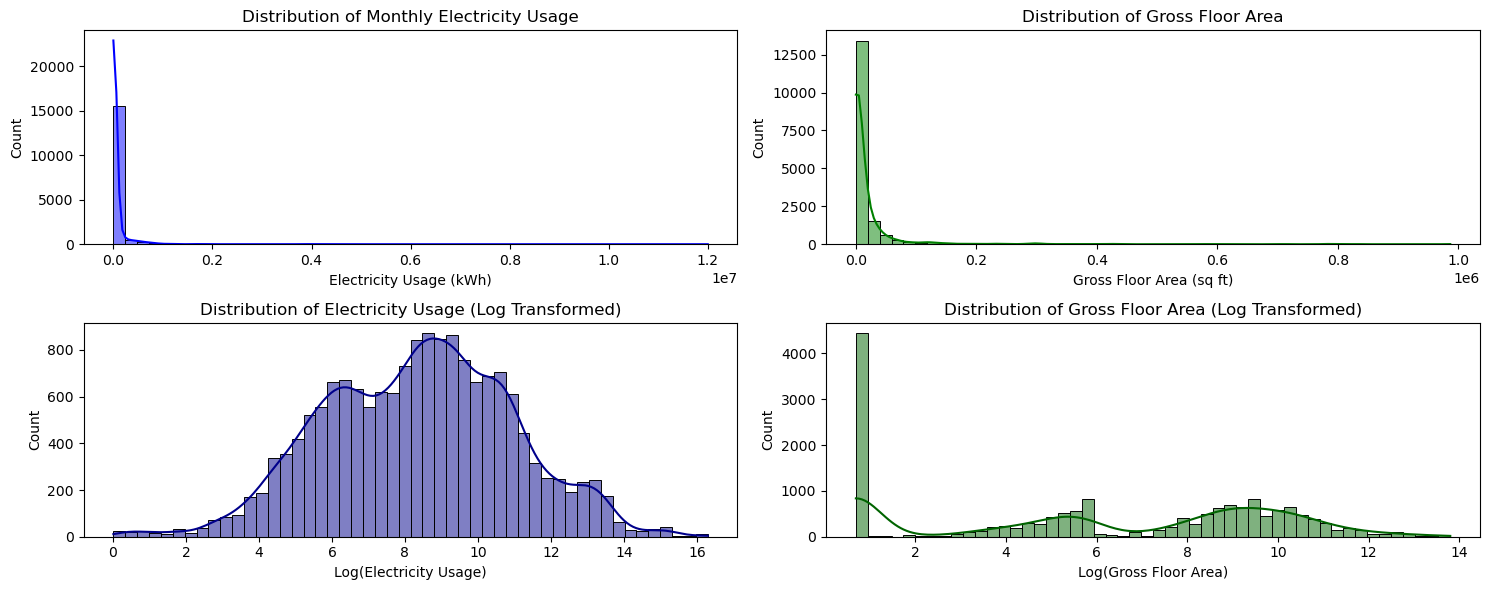

In [21]:
# ----- 2. Distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 6))

# ---- Row 1: Original Distributions
# --- Plot 1: Distribution of Electricity Usage
sns.histplot(
    data = df_merged["Electricity_Usage_kWh"],
    bins = 50,
    kde = True,
    ax = axes[0, 0],
    color = "blue")
axes[0, 0].set_title("Distribution of Monthly Electricity Usage")
axes[0, 0].set_xlabel("Electricity Usage (kWh)")

# --- Plot 2: Distribution of Gross Floor Area
sns.histplot(
    df_merged["Gross_Floor_Area_sqft"],
    bins = 50,
    kde = True,
    ax = axes[0, 1],
    color = "green")
axes[0, 1].set_title("Distribution of Gross Floor Area")
axes[0, 1].set_xlabel("Gross Floor Area (sq ft)")


# ---- Row 2: Log Transformed Distributions
# We use np.log1p (Log(x+1)) to simulate the transformation we will do later
# --- Plot 3: Electricity Usage (Log Scale)
sns.histplot(
    x = np.log1p(df_merged["Electricity_Usage_kWh"]),
    bins = 50,
    kde = True,
    ax = axes[1, 0],
    color = "darkblue"
)
axes[1, 0].set_title("Distribution of Electricity Usage (Log Transformed)")
axes[1, 0].set_xlabel("Log(Electricity Usage)")

# --- Plot 4: Gross Floor Area (Log Scale)
sns.histplot(
    x = np.log1p(df_merged["Gross_Floor_Area_sqft"]),
    bins = 50,
    kde = True,
    ax = axes[1, 1],
    color = "darkgreen"
)
axes[1, 1].set_title("Distribution of Gross Floor Area (Log Transformed)")
axes[1, 1].set_xlabel("Log(Gross Floor Area)")

# ---- Show plots
plt.tight_layout()
plt.show()

***Insight:***
   * We have a "long tail" to the right, it means we have outliers (a skewed distribution).

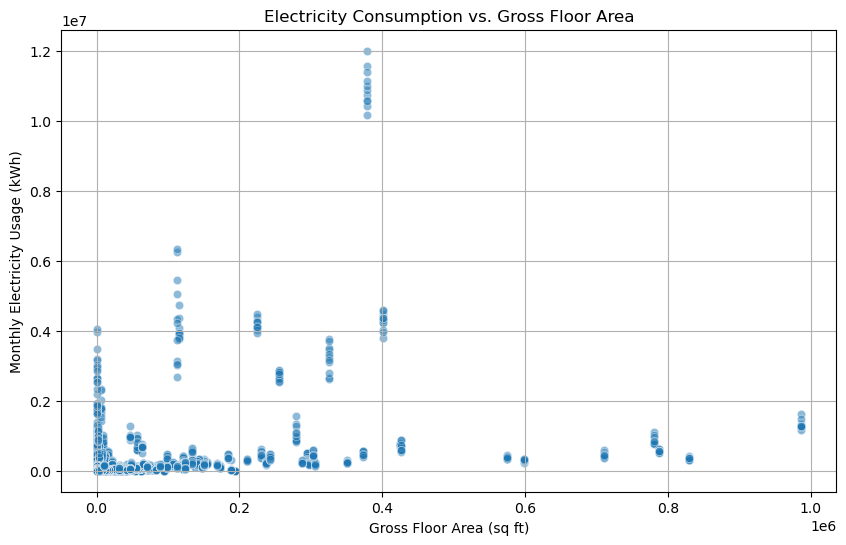

In [22]:
# ----- 3. Relationship: Floor Area vs. Energy Consumption
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data = df_merged,
    x = "Gross_Floor_Area_sqft",
    y = "Electricity_Usage_kWh",
    alpha = 0.5)
plt.title("Electricity Consumption vs. Gross Floor Area")
plt.xlabel("Gross Floor Area (sq ft)")
plt.ylabel("Monthly Electricity Usage (kWh)")
plt.grid(True)
plt.show()


***Insight Check:***
   * High quantity of outliers
   * There is not a clear pattern that describe the relation between 'Gross Floor Area (sq ft)' and 'Electricity Usage (kWh)'
   * High concentration of data near to origin (0, 0)

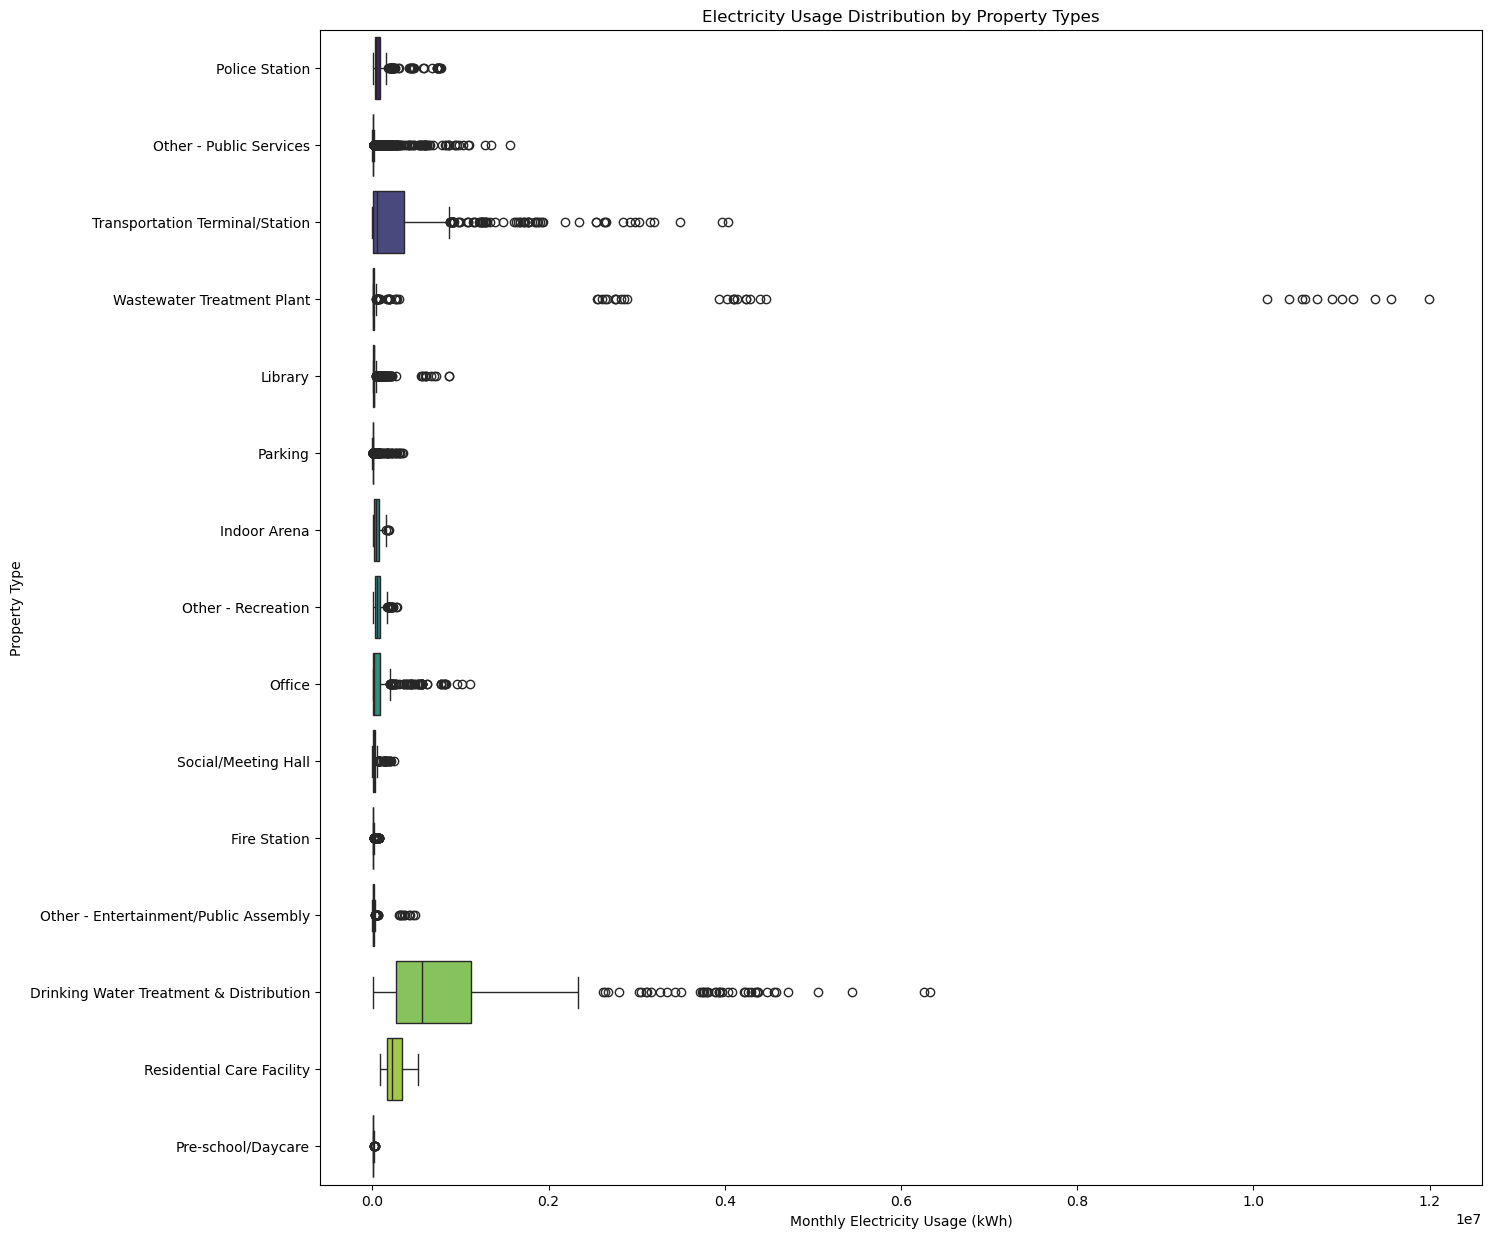

In [23]:
# ----- 4. Consumption by Property Type Option 1
plt.figure(figsize=(15, 15))
sns.boxplot(
    data = df_merged, 
    x = "Electricity_Usage_kWh", 
    y = "Property_Type",
    hue = "Property_Type",
    legend = False,
    palette = "viridis")

plt.title("Electricity Usage Distribution by Property Types")
plt.xlabel("Monthly Electricity Usage (kWh)")
plt.ylabel("Property Type")
plt.show()

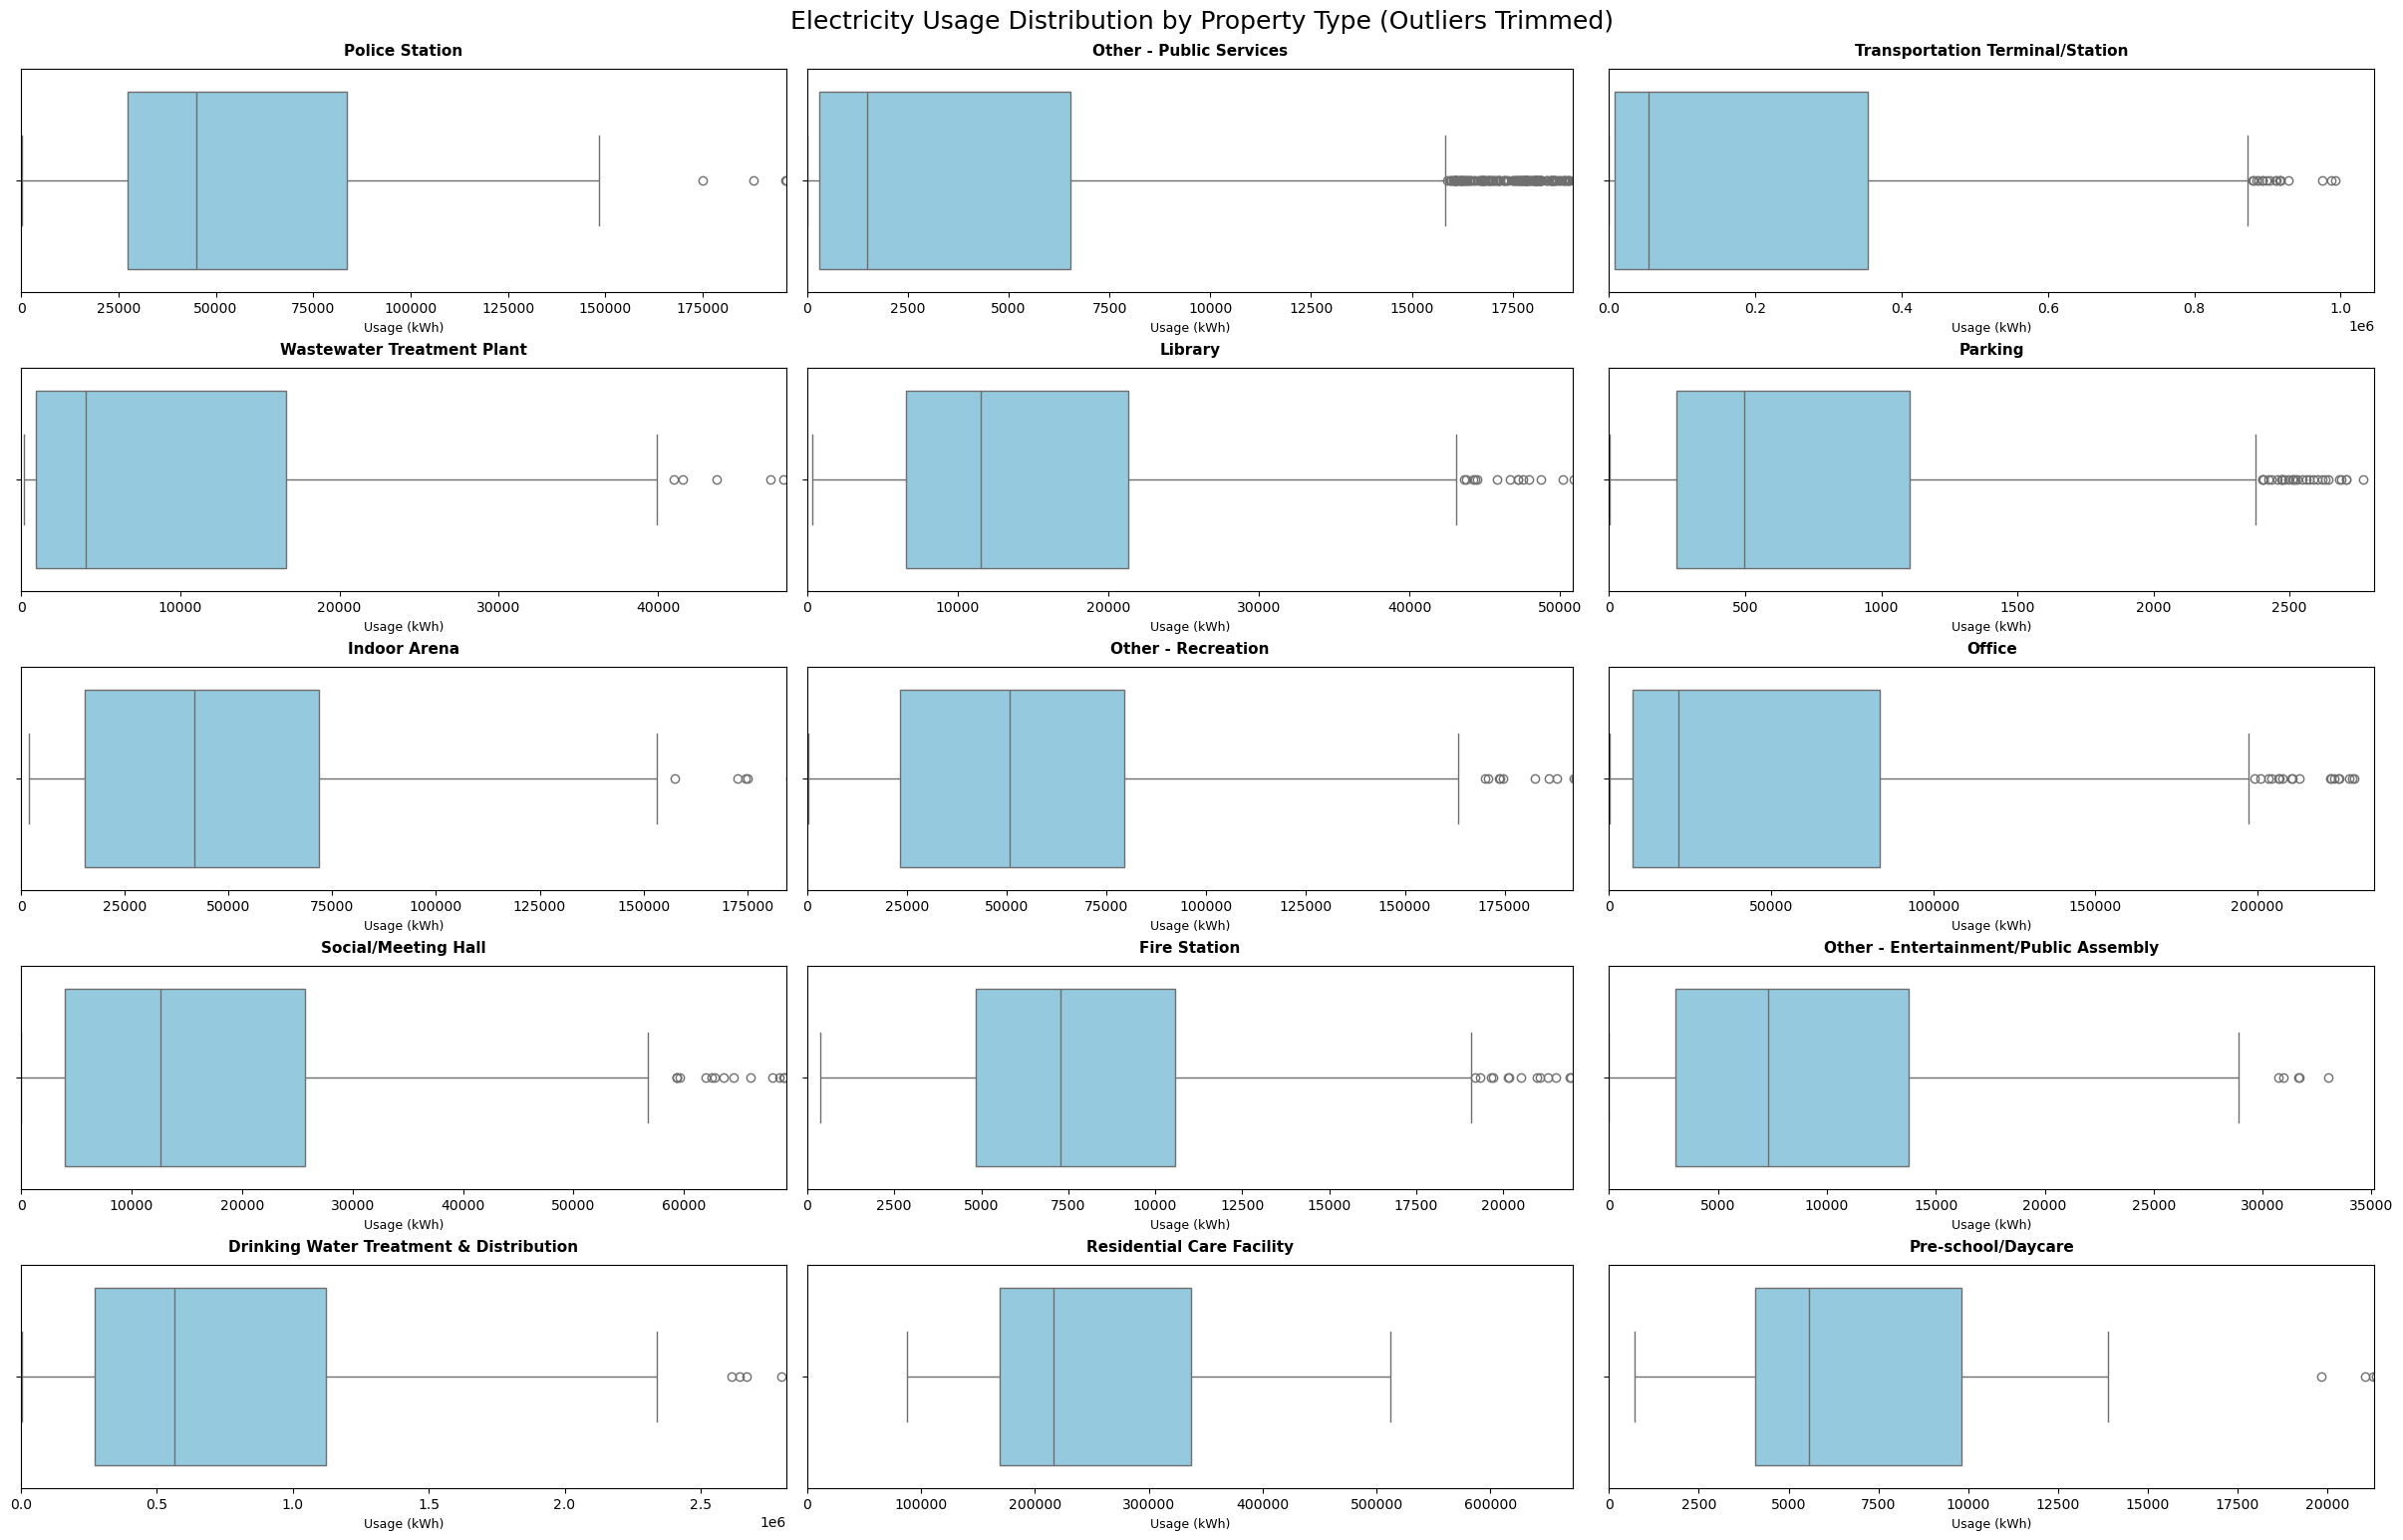

In [24]:
# ----- 4. Consumption by Property Type Option 2
plot_property_type_subplots(df_merged)

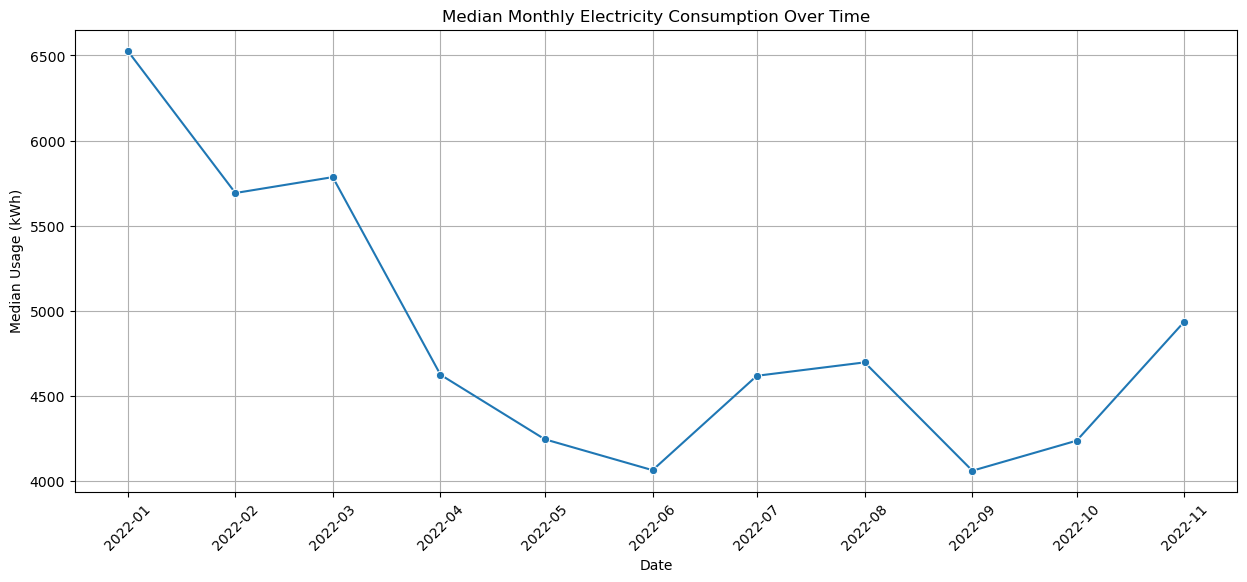

In [25]:
# ----- 5. Time Series Trends
# --- Group by Start Date to see the total consumption trend over time
#df_monthly_trend = df_merged.copy()
df_monthly_trend = df_merged.groupby("Start Date")["Electricity_Usage_kWh"].median().reset_index()

plt.figure(figsize=(15, 6))
sns.lineplot(
    data = df_monthly_trend,
    x = "Start Date",
    y = "Electricity_Usage_kWh",
    marker = "o")
plt.title("Median Monthly Electricity Consumption Over Time")
plt.xlabel("Date")
#plt.ylabel("Usage (kWh)")
plt.ylabel("Median Usage (kWh)")
plt.grid(True)
plt.xticks(rotation = 45)
plt.show()

**Insight & Explanation**

* Winter Peak (Nov–Mar): Two main factors:
    - Heating: Even if many buildings use Natural Gas for heat, pumps and fans run harder. Plus, many buildings likely do have electric heating (baseboard or auxiliary), which causes massive spikes in consumption.
    - Lighting: Days are much shorter in Ontario winters, leading to significantly higher lighting loads compared to summer.

* Summer Peak (July–Aug): This is driven almost entirely by Air Conditioning (Cooling). It is a sharp, distinct peak during the hottest months.

* Shoulder Seasons (Apr–May, Sept–Oct): "valleys" or lowest points here. This is when the weather is mild, so neither heating nor cooling is running at full capacity.

,Electricity_Usage_kWh,Gross_Floor_Area_sqft
Electricity_Usage_kWh,1.0000,0.3486
Gross_Floor_Area_sqft,0.3486,1.0000


************************************************** 



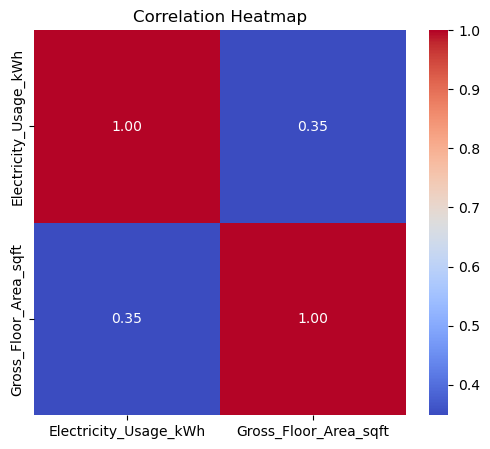

In [26]:
# ----- 6. Correlation Matrix
# --- Select only numeric columns (relevant for correlation)
corr_cols = ["Electricity_Usage_kWh", "Gross_Floor_Area_sqft"]
correlation_matrix = df_merged[corr_cols].corr()
display(correlation_matrix)

print("*" * 50, "\n")

plt.figure(figsize=(6, 5))
sns.heatmap(
    data = correlation_matrix,
    annot = True,
    cmap = "coolwarm",
    fmt = ".2f")
plt.title("Correlation Heatmap")
plt.show()

#### Insights and Actions of EDA

   * Distributions: Are the values normal (bell curve) or skewed?
	   - Both charts of distribution are right skewed.
		   - Histogram of Electircity Usage (kWh)
		   - Histogram of Gross Floor Area (sq ft)

   * Correlations: Is there a strong relationship between Area and Usage?
	   - There is a correlation, not so clear on the scatter plot.
	   - In the correlation matrix and heatmap the correlation has a value of 0.3486, confim the low positive correlation.

   * Seasonality: Does the line chart go up in Summer (July/Aug) or Winter (Jan/Feb)?
	   - Yes, at the end of February and all march the median usage is clearly high.
	   - On april and for a small period in october the usase is lower compared with the other months

### CHAPTER 3. Visualization

Use visual tools to support and communicate insights.
   * Include plots such as histograms, bar charts, boxplots, or correlation heatmaps.
   * Label axes, titles, and legends clearly.
   * Include visualizations that add value to your analysis.
   * In your report, include figures that convey important insights and explain what they show.


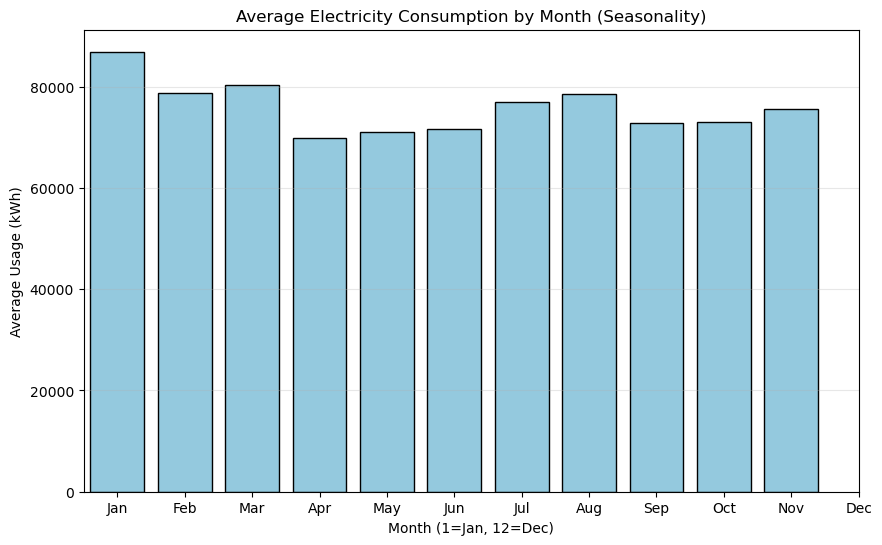

In [27]:
# ----- Visualization 1: Seasonality Profile
# ---- Extract month from the date
df_merged["Month"] = df_merged["Start Date"].dt.month

# ---- Calculate average usage per month across all buildings
monthly_profile = df_merged.groupby("Month")["Electricity_Usage_kWh"].mean()

plt.figure(figsize=(10, 6))
# --- Plot as a bar chart
sns.barplot(
    x = monthly_profile.index,
    y = monthly_profile.values,
    color = "skyblue",
    edgecolor = "black"
    )

plt.title("Average Electricity Consumption by Month (Seasonality)")
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.ylabel("Average Usage (kWh)")
plt.xticks(ticks=range(0, 12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(axis="y", alpha=0.3)
plt.show()

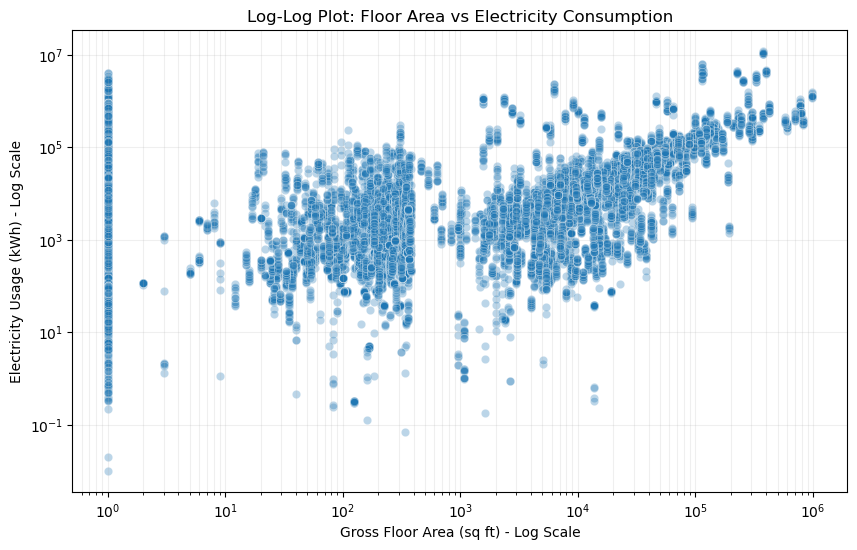

In [28]:
# ----- Visualization 2: Log-Log Scatter Plot (Area vs Usage)
plt.figure(figsize=(10, 6))

# ---- We use log scale for both axes
sns.scatterplot(
    data = df_merged,
    x = "Gross_Floor_Area_sqft",
    y = "Electricity_Usage_kWh",
    alpha=0.3 )
plt.xscale("log")
plt.yscale("log")

plt.title("Log-Log Plot: Floor Area vs Electricity Consumption")
plt.xlabel("Gross Floor Area (sq ft) - Log Scale")
plt.ylabel("Electricity Usage (kWh) - Log Scale")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

# Insight: Notice how the "blob" is much tighter/linear here compared to your previous scatter plot?

***Insight Check:***
   * Notice how the "blob" is much tighter/linear here compared to your previous scatter plot. Just using the log transformation.

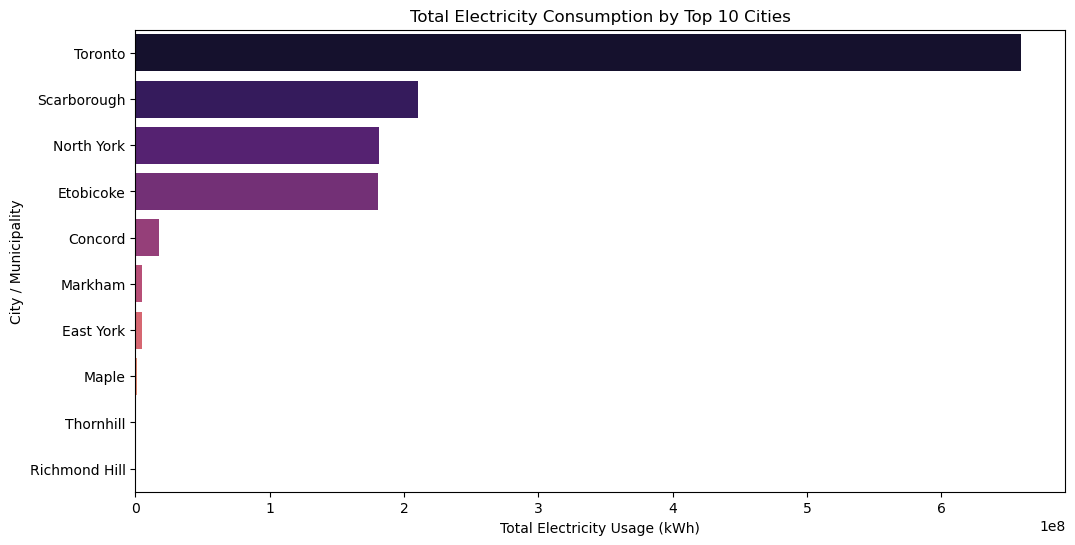

In [29]:
# ----- Visualization 3: Top Cities by Total Consumption
# ---- Summing usage by city to see where the energy is going
city_usage = df_merged.groupby("City/Municipality")["Electricity_Usage_kWh"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(
    x = city_usage.values,
    y = city_usage.index,
    palette = "magma",
    hue = city_usage.index,
    legend = False )

plt.title("Total Electricity Consumption by Top 10 Cities")
plt.xlabel("Total Electricity Usage (kWh)")
plt.ylabel("City / Municipality")
plt.show()

#### Insights and Actions of Visualizations

   * We only have 11 months of data. The higher consume is on January
   * The relationship between 'Gross_Floor_Area_sqft' and 'Electricity_Usage_kWh' is clearly with the plot applying log to the variables.
   * We discover that the higher consumption of energy is on 4 cities: Toronto, Scarborough, North York, Etobicoke

### CHAPTER 4. Feature Engineering

Prepare the dataset for modeling.

   * Create new features where appropriate.
   * Encode categorical variables.
   * Normalize or scale numeric features if needed.
   * In your report, justify why certain features or transformations were used. Explain the reasoning behind selected features and transformations.


#### Steps

   1. Log Transformation: Apply the log math to "squash" the skewed data (Area and Usage).
   2. Date Features: Extract the "Month" so the model knows that "January" usually means "High Heating".
   3. One-Hot Encoding: Convert text categories (like "Office" or "Toronto") into 1s and 0s.
   4. Train-Test Split: Separate the data to ensure honest testing later.

In [30]:
# --- 1. Create new variables

# Effective Area (scaled by occupancy)
#df_merged['Effective_Area'] = (df_merged['Gross_Floor_Area_sqft'] * df_merged['Occupancy (%)']) / 100
print(f"Rows before filtering area 0: {len(df_merged)}") 
#df_merged = df_merged[df_merged["Effective_Area"] > 0].copy() #Filter area 0
df_merged = df_merged[df_merged["Gross_Floor_Area_sqft"] > 0].copy() #Filter area 0

print(f"Rows after filtering (Effective_Area > 0): {len(df_merged)}")

# Check the first rows
#df_merged[['Gross_Floor_Area_sqft', 'Occupancy (%)', 'Effective_Area']].head()
df_merged[['Gross_Floor_Area_sqft', 'Occupancy (%)', 'Gross_Floor_Area_sqft']].head()

Rows before filtering area 0: 16627
Rows after filtering (Effective_Area > 0): 16627


,Gross_Floor_Area_sqft,Occupancy (%),Gross_Floor_Area_sqft
0,20344,100,20344
1,20344,100,20344
2,20344,100,20344
3,20344,100,20344
4,20344,100,20344


In [31]:
# ----- 1. Log Transformation
# ---- We apply log1p (natural log + 1) to handle skewness
df_merged["Log_Gross_Floor_Area"] = np.log1p(df_merged["Gross_Floor_Area_sqft"])
df_merged["Log_Electricity_Usage"] = np.log1p(df_merged["Electricity_Usage_kWh"])

# ----- 2. Date Features
# ---- Extract Month to capture seasonality
df_merged["Month"] = df_merged["Start Date"].dt.month

# ---- Check the new columns
print("New features created: 'Log_Gross_Floor_Area', 'Log_Electricity_Usage', 'Month'")
df_merged[["Gross_Floor_Area_sqft", "Log_Gross_Floor_Area", "Electricity_Usage_kWh", "Log_Electricity_Usage", "Month"]].head()

New features created: 'Log_Gross_Floor_Area', 'Log_Electricity_Usage', 'Month'


,Gross_Floor_Area_sqft,Log_Gross_Floor_Area,Electricity_Usage_kWh,Log_Electricity_Usage,Month
0,20344,9.9206,"42,876.2700",10.6661,1
1,20344,9.9206,"39,721.7200",10.5897,2
2,20344,9.9206,"41,278.0400",10.6281,3
3,20344,9.9206,"37,111.9500",10.5217,4
4,20344,9.9206,"41,778.2700",10.6402,5


In [32]:
# ----- 3. Encoding Categorical Variables
# ---- We use One-Hot Encoding (pd.get_dummies) for Property Type and City.
#       drop_first=True prevents "dummy variable trap" (collinearity)

# --- Columns before encoding
print(f"Shape before encoding: {df_merged.shape}")

# --- Select categorical columns to encode
categorical_cols = ["Property_Type", "City/Municipality"]

# --- Create dummy variables
df_encoded = pd.get_dummies(df_merged, columns=categorical_cols, drop_first=True)

print(f"Shape after encoding: {df_encoded.shape}")

Shape before encoding: (16627, 22)
Shape after encoding: (16627, 44)


***Insight:***

The categorical features, such as Property_Type and City/Municipality, were transformed into binary dummy variables using one-hot encoding. This allows the machine learning models to process these non-numeric attributes effectively. We used drop_first=True to avoid multicollinearity, which removes one dummy column per feature as a reference category.

In [33]:
# ----- 4. Define Features (X) and Target (y)

# ---- Target: We predict the LOG usage (we will reverse this later to get real kWh)
y = df_encoded["Log_Electricity_Usage"]

# ---- Features: Drop the target and the original non-log columns
drop_cols = [
    "Electricity_Usage_kWh", "Log_Electricity_Usage", # Targets
    "Gross_Floor_Area_sqft", # We use the Log version instead
    "Start Date", "End Date", # We extracted Month
    "Portfolio Manager ID", "Property Name", "Street Address", "Postal Code", # IDs/Text not useful for prediction
    "Property Name_x", "Property Name_y", # Columns created by the merge steps.
    "Meter Name", "Meter Type", "Usage Units", # Metadata
    "Cost ($)", "Meter Consumption ID", "Portfolio Manager Meter ID", # Metadata
    "Occupancy (%)" # No longer needed after filtering and cleaning
]

# ---- Drop columns that exist in the dataframe
cols_to_drop = [c for c in drop_cols if c in df_encoded.columns]
X = df_encoded.drop(columns=cols_to_drop)

print(f"Features (X) Shape: {X.shape}")
print(f"Target (y) Shape: {y.shape}")

display(X.info())

Features (X) Shape: (16627, 27)
Target (y) Shape: (16627,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16627 entries, 0 to 16626
Data columns (total 27 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Billing_Days                                         16627 non-null  int64  
 1   Month                                                16627 non-null  int32  
 2   Log_Gross_Floor_Area                                 16627 non-null  float64
 3   Property_Type_Fire Station                           16627 non-null  bool   
 4   Property_Type_Indoor Arena                           16627 non-null  bool   
 5   Property_Type_Library                                16627 non-null  bool   
 6   Property_Type_Office                                 16627 non-null  bool   
 7   Property_Type_Other - Entertainment/Public Assembly  16627 non-null  bool   
 8   Propert

None

In [34]:
# ----- 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size = c_test_size, 
    random_state = c_random_state )

print(f"Training Data: {X_train.shape}")
print(f"Testing Data: {X_test.shape}")

Training Data: (13301, 27)
Testing Data: (3326, 27)


#### Insights and Actions of Feature Engineering

   * Transformation: "We applied a Log Transformation to Floor Area and Usage because the EDA showed a power-law distribution. This linearized the relationship."

   * Encoding: "We used One-Hot Encoding for Property Type and City to allow the model to distinguish between building categories."

   * Seasonality: "We extracted the 'Month' from the date to allow the model to learn seasonal energy patterns."

### CHAPTER 5. Model Building

Develop prediction models using the cleaned dataset.
   * Build at least two different models (e.g., different algorithms or pipelines).
   * Use an appropriate train–test split.
   * Apply preprocessing such as scaling or encoding when required.
   * Tune hyperparameters where helpful.
   * In your report, describe each model at a high level and the motivation for using it.


In [35]:
# ----- Model 1: Linear Regression Pipeline
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),      # Step 1: Scale data
    ('regressor', LinearRegression())  # Step 2: The Algorithm
])

# --- Train the model
print("Training Linear Regression Model...")
pipe_lr.fit(X_train, y_train)
print("Linear Regression Training Complete.")

Training Linear Regression Model...
Linear Regression Training Complete.


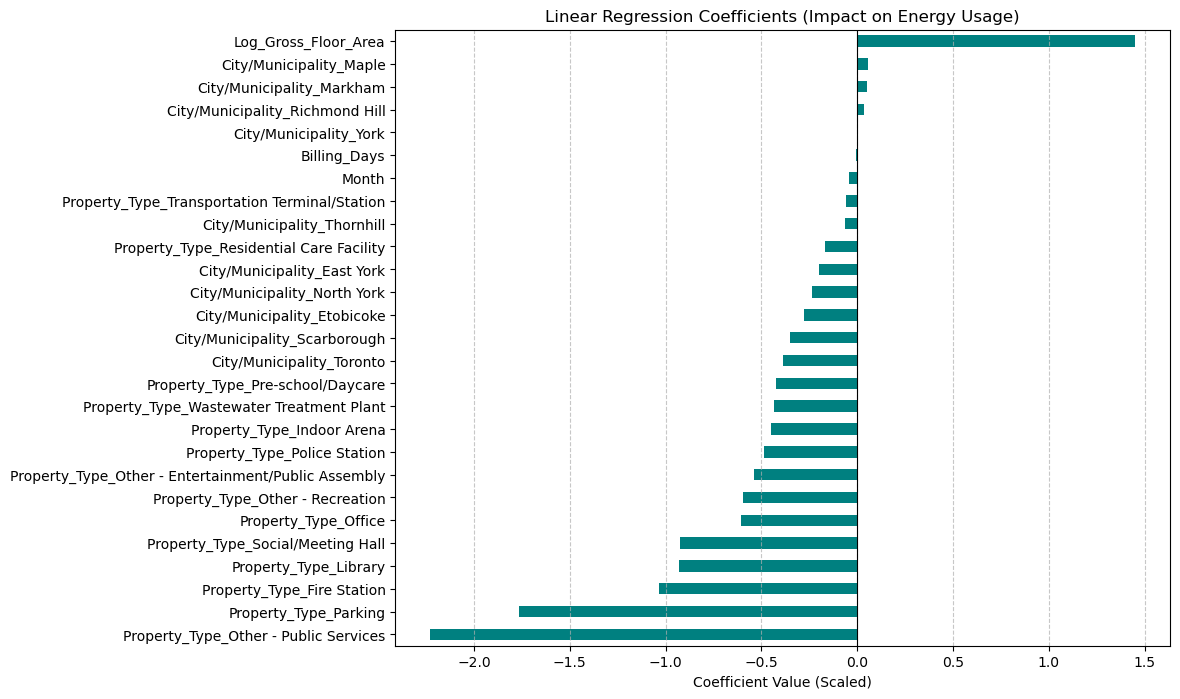

In [36]:
# --- Visualizing Linear Regression Coefficients
# 1. Extract the model from the pipeline
linear_model = pipe_lr.named_steps['regressor']

# 2. Get the coefficients
coefficients = linear_model.coef_

# 3. Create a Series for plotting
# We sort by value to see positive (increases energy) vs negative (decreases energy) impacts
lr_importance = pd.Series(coefficients, index=X.columns)
sorted_lr_importance = lr_importance.sort_values()

# 4. Plot
plt.figure(figsize=(10, 8))
sorted_lr_importance.plot(kind='barh', color='teal')
plt.title("Linear Regression Coefficients (Impact on Energy Usage)")
plt.xlabel("Coefficient Value (Scaled)")
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8) # Add a center line for 0
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


Training Gradient Boosting Model (this may take a moment)...
Gradient Boosting Training Complete.


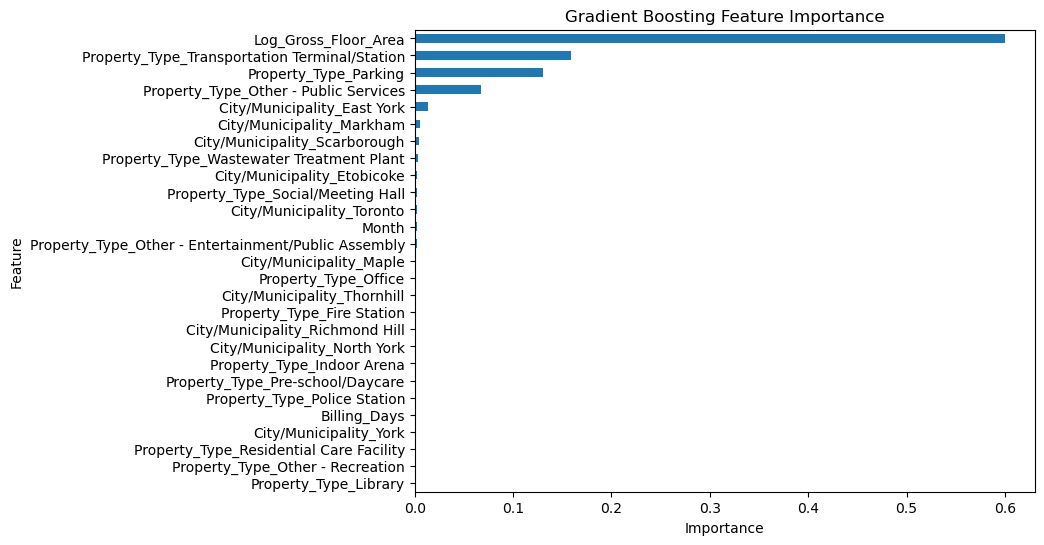

In [37]:
# ----- Model 2: Gradient Boosting Regressor

pipe_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# --- Train the model
print("\nTraining Gradient Boosting Model (this may take a moment)...")
pipe_gb.fit(X_train, y_train)
print("Gradient Boosting Training Complete.")

# --- Feature importance
model_gb = pipe_gb.named_steps['regressor']

feat_importance_gb = pd.Series(model_gb.feature_importances_, index=X_train.columns)
feat_importance_gb.sort_values().plot(
    kind='barh', 
    title="Gradient Boosting Feature Importance", 
    figsize=(8,6)
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [38]:
# ----- Model 3: Random Forest Regressor
# --- This model does not require scaling, so we can use the algorithm directly.
model_rf = RandomForestRegressor(
    n_estimators=100,  # Number of trees
    random_state=c_random_state,
    n_jobs=-1          # Use all computer cores to speed up training
)

# --- Train the model
print("\nTraining Random Forest Model (this may take a moment)...")
model_rf.fit(X_train, y_train)
print("Random Forest Training Complete.")


Training Random Forest Model (this may take a moment)...
Random Forest Training Complete.


In [39]:
# feat_importance = pd.Series(model_rf.feature_importances_, index = X.columns)
# feat_importance.sort_values().plot(kind = 'barh', title = "Feature Importance")
# plt.show()

Running hyperparameter tuning...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters Found:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


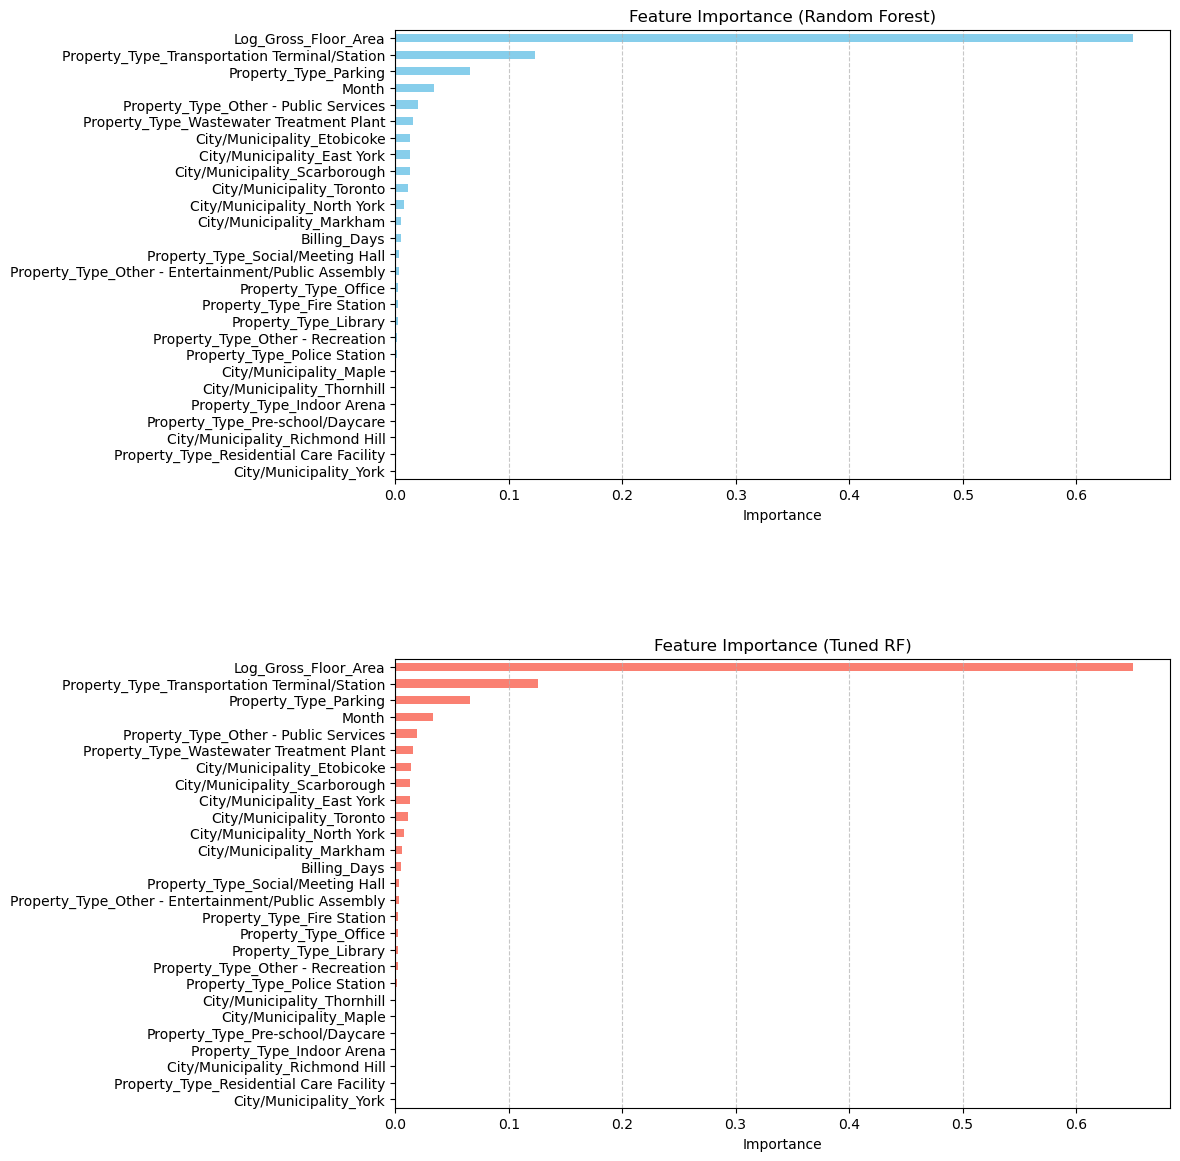

In [40]:
# ----- Model 4: Tuned Random Forest Regressor

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=c_random_state),
    param_grid=param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

print("Running hyperparameter tuning...")
grid_search.fit(X_train, y_train)

print("Best Parameters Found:")
print(grid_search.best_params_)

best_rf = grid_search.best_estimator_


# Feature importance for both models
feat_importance = pd.Series(model_rf.feature_importances_, index=X.columns).sort_values()
feat_importance_tuned = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values()

# Create a figure with 2 rows and 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 14)) 

# Plot both models
feat_importance.plot(kind='barh', ax=axes[0], title="Feature Importance (Random Forest)", color='skyblue')
axes[0].set_xlabel('Importance')
axes[0].grid(axis='x', linestyle='--', alpha=0.7) 
feat_importance_tuned.plot(kind='barh', ax=axes[1], title="Feature Importance (Tuned RF)", color='salmon')
axes[1].set_xlabel('Importance')
axes[1].grid(axis='x', linestyle='--', alpha=0.7)

plt.subplots_adjust(hspace=0.4)
plt.show()

#### Insights and Actions of Model Building

   * We first evaluated the default Random Forest model and plotted its feature importance.
   * After tuning hyperparameters using GridSearchCV, we trained our optimized Random Forest model.
   * Because hyperparameter tuning changes the structure of the trees, feature importances also change, so we plotted a second importance chart based on the tuned model. This allows us to compare how model optimization influences variable relevance.

### CHAPTER 6. Model Evaluation

Assess model performance thoroughly.

   * Use appropriate metrics for your task.
   * Compare model performance and discuss strengths and weaknesses.
   * Visualize errors or residuals where relevant.
   * Consider issues such as outliers or skewed distributions. You may go back and improve your work in previous steps.
   * **IMPORTANT**: In your report, interpret what the evaluation results mean in context.


#### Steps

We need to calculate two key metrics:
   1. RMSE (Root Mean Squared Error): This tells us, on average, how far off our predictions are. Lower is better.
   2. R^2 Score (R-Squared): This tells us how much of the variance in energy usage our model explains. Closer to 1.0 (100%) is better.

In [41]:
# ----- Model Evaluation
# --- NOTE: Use the evaluate_model function (Print RMSE and R2 for Train and Test sets)
#               Also returns the Test predictions to be able to use for plot or something else.

# --- 1. Evaluate Linear Regression
y_pred_lr = evaluate_model(pipe_lr, X_train, y_train, X_test, y_test, "Linear Regression")

print("*" * 50, "\n")
# --- 2. Evaluate Gradient Boosting Regressor
y_pred_gb = evaluate_model(pipe_gb, X_train, y_train, X_test, y_test, "Gradient Boosting")

print("*" * 50, "\n")
# --- 3. Evaluate Random Forest
y_pred_rf = evaluate_model(model_rf, X_train, y_train, X_test, y_test, "Random Forest")

print("*" * 50, "\n")
# --- 4. Evaluate Tuned Random Forest
y_pred_rf_tuned = evaluate_model(best_rf, X_train, y_train, X_test, y_test, "Tuned Random Forest")

print("*" * 50, "\n")

--- Linear Regression Performance ---
Training RMSE: 1.8185 | R2: 0.5040
Testing  RMSE: 1.7694  | R2: 0.5246
------------------------------
************************************************** 

--- Gradient Boosting Performance ---
Training RMSE: 1.6965 | R2: 0.5683
Testing  RMSE: 1.6632  | R2: 0.5799
------------------------------
************************************************** 

--- Random Forest Performance ---
Training RMSE: 1.1807 | R2: 0.7909
Testing  RMSE: 1.2078  | R2: 0.7784
------------------------------
************************************************** 

--- Tuned Random Forest Performance ---
Training RMSE: 1.1803 | R2: 0.7911
Testing  RMSE: 1.2080  | R2: 0.7784
------------------------------
************************************************** 



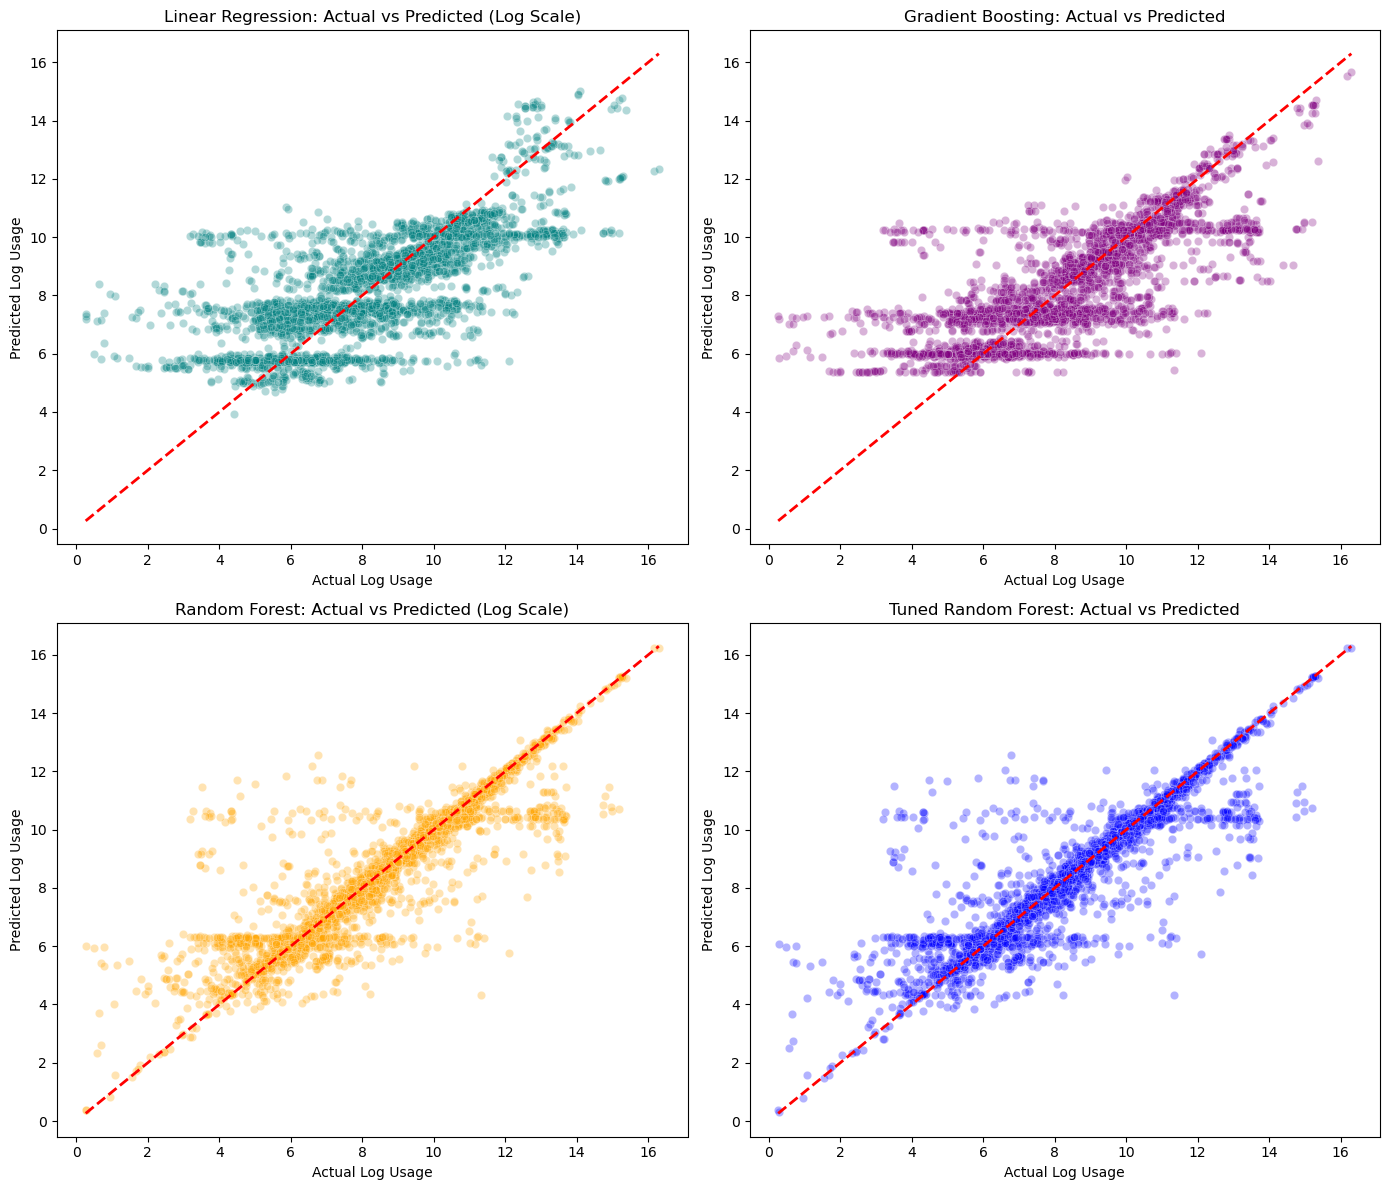

In [42]:
# --- 3. Visualize Residuals (Predicted vs Actual)
plt.figure(figsize=(14, 12))

# -- 3.a. Plot Linear Regression
plt.subplot(2, 2, 1)
sns.scatterplot(
    x = y_test,
    y = y_pred_lr,
    alpha = 0.3,
    color = "teal" )
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2) # Diagonal line
plt.title("Linear Regression: Actual vs Predicted (Log Scale)")
plt.xlabel("Actual Log Usage")
plt.ylabel("Predicted Log Usage")

# -- 3.b. Plot Gradient Boosting
plt.subplot(2, 2, 2)
sns.scatterplot(
    x=y_test,
    y=y_pred_gb,
    alpha=0.3,
    color="purple"
)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Gradient Boosting: Actual vs Predicted")
plt.xlabel("Actual Log Usage")
plt.ylabel("Predicted Log Usage")

# -- 3.c. Plot Random Forest
plt.subplot(2, 2, 3)
sns.scatterplot(
    x=y_test,
    y=y_pred_rf,
    alpha=0.3,
    color="orange"
)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Random Forest: Actual vs Predicted (Log Scale)")
plt.xlabel("Actual Log Usage")
plt.ylabel("Predicted Log Usage")

# -- 3.d. Plot Tuned Random Forest
plt.subplot(2, 2, 4)
sns.scatterplot(
    x=y_test,
    y=y_pred_rf_tuned,
    alpha=0.3,
    color="blue"
)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title("Tuned Random Forest: Actual vs Predicted")
plt.xlabel("Actual Log Usage")
plt.ylabel("Predicted Log Usage")

plt.tight_layout()
plt.show()

#### Insights and Actions of Evaluation Model

   * We plot the Actual values (x-axis) vs Predicted values (y-axis) for the Test set.
      - A perfect model would be a straight diagonal line.
   * Model Score Interpretation:
      - Linear Regression (R^2 ≈ 0.52): This low score confirms that the relationship between your features (like Size and Month) and Electricity Usage is not strictly linear. A straight line simply cannot capture the complex patterns of how buildings use energy (e.g., HVAC systems turning on/off, non-linear occupancy curves).
      - Gradient Boosting Regressor (R² ≈ 0.58): This model shows moderate improvement over Linear Regression, capturing some non-linear patterns, but it underperforms compared to the Random Forest models. The slightly higher RMSE indicates that the model predictions are somewhat less accurate for this dataset.  
      - Random Forest (R^2 ≈ 0.78): The massive jump in performance proves that data contains non-linear patterns that the decision trees are successfully finding.
      - Tuned Random Forest (R² ≈ 0.78): Hyperparameter tuning slightly improved the performance compared to the default Random Forest, reducing RMSE and increasing R² on the test set. This indicates that optimizing the number of trees, depth, and leaf/split parameters helps the model better capture subtle patterns in the data. The improvements are small, overall, the Tuned Random Forest is the best-performing model among all methods, providing more accurate predictions for electricity usage.    

### Insights, Interpretation, and Reporting

Synthesize your findings into a coherent narrative.

   * Summarize key insights found during EDA.
      - Our analysis of Ontario’s building energy data revealed three fundamental characteristics that dictated our modeling strategy:The Power-Law Distribution: Energy usage and Gross Floor Area are not normally distributed. They are heavily right-skewed, with a vast majority of small/medium consumers and a few massive "megastructures" (e.g., Water Treatment Plants) that consume exponentially more energy.
      - The Log-Linear Relationship: While the raw correlation between Size and Usage was moderate (0.35), transforming both variables to a Logarithmic Scale revealed a strong, linear relationship. This confirms that building energy consumption scales geometrically, not linearly.
      - Distinct Seasonality: The time-series analysis uncovered a clear "Winter Peak" (November–March) driven by heating and lighting loads, and a secondary "Summer Peak" (July–August) driven by air conditioning. This seasonality confirms that the Month is a critical predictor variable.

   * Discuss which factors appear to influence energy consumption.
      - the primary drivers of electricity consumption are:
      - Gross Floor Area: This is unequivocally the dominant factor. Larger buildings invariably consume more energy, but the relationship is non-linear (doubling the size doesn't exactly double the usage; it often scales differently depending on building efficiency).
      - Building Type: The operational nature of the building significantly impacts the "Base Load." For example, a Police Station or Hospital (24/7 operations) has a much higher energy intensity per square foot compared to a Storage Facility or Park, even if they are the same size.
      - Seasonality (Month): Weather dependency is a strong third factor. Buildings in Ontario fight against the cold for 5 months of the year, creating a distinct "heating penalty" that the models must account for.

   * Explain why certain models performed better than others.
      - Linear Regression assumes a straight-line relationship between inputs and outputs. While our Log-Transformation helped, the complex interactions (e.g., a large building typically uses more energy, BUT only if it is occupied AND it is winter) are too intricate for a simple linear equation to capture.
      - Gradient Boosting learns sequentially, correcting the errors of previous trees
         - Cons: It is highly sensitive to noise and outliers. Gradient Boosting tries too hard to "fix" these errors, sometimes leading to overfitting on the noise rather than the signal.
      - Robustness: This averaging process naturally "smooths out" the noise and outliers that confused the Gradient Boosting model.
         - Non-Linearity: Unlike Linear Regression, it easily captures complex "if-then" logic (e.g., If Building=Hospital AND Month=January -> High Usage).
         - Conclusion: For this specific real-world dataset, which contains inherent noise and diverse building behaviors, the robustness of Random Forest proved superior to the sensitivity of Gradient Boosting.

   * Acknowledge limitations, assumptions, or data quality issues.
      - Partial Month Readings: The raw data contained meter readings spanning irregular intervals. We point to get only full bill months.

      - The "Occupancy" Proxy: We relied on the Occupancy (%) column, but found it was almost binary (0% or 100%). We lacked granular data (e.g., "50% occupied"), meaning our model assumes a building is either "Full" or "Empty,". At the end decide to not consider the "Empty" buildings.

      - Missing Variables: We predicted usage based on static attributes (Size, Type). We lacked dynamic attributes like average temperature, insulation quality, or HVAC efficiency rating, which are physical drivers of energy use.

   * Suggest practical real-world implications or possible next steps.
      - Anomaly Detection: We can run every building in the portfolio through our Random Forest model. If a building's Actual Usage is significantly higher than the Predicted Usage, it is an "Energy Waster." Facility managers should dispatch a team to inspect that specific site for faults.

      - Retrofit Targeting: By identifying buildings that perform worse than their peers (controlling for Size and Type), the city can prioritize retrofits (e.g., LED lighting, new insulation) where they will yield the highest ROI.

      - Future Work: The logical next step is to integrate Weather Data (HDD/CDD). Merging this dataset with historical temperature records would allow the model to distinguish between a "cold winter" usage spike and a "broken heater" usage spike.

   * Write your report **clearly, logically, and professionally**.
